In [1]:
import pandas as pd
import os 
import sys
import numpy as np
import sklearn
import time
import copy
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [2]:
#create single pose dataset for dnn model
class SinglePoseDataset(Dataset):
    
    def __init__(self, n_frames=5):
        
        # get data and label from csvget 
        dataset, labels = SinglePoseDataset.ReadPoseData(n_frames)
        print('dataset shape:',dataset.shape, 'labels shape', labels.shape)
        
        self.X = dataset
        self.y = labels
    
    # read dataset from csv file
    @staticmethod
    def ReadPoseData(n_frames):
        
        # get csv file path
        curr_dir = os.getcwd()
        csv_file_path = os.path.join(curr_dir, 'data/clean_res.csv')
        
        # list for storing data and labels
        data  = []
        label = []
        
        # lenth of sequence
        #n_frames = SinglePoseDataset.n_frames
        
        # read csv file
        KP_df = pd.read_csv(csv_file_path)
        
        # convert pos_class to categories
        KP_df['pos_class'] = KP_df['pos_class'].astype('category')
        KP_df['pos_class'] = KP_df['pos_class'].cat.codes

        # skipping (0-3) colomns , return values of all rows and columns from 4 to last
        features = KP_df.iloc[:,5:].values
        #return values of pose_class 
        pose_class = KP_df['pos_class'].values
        # normalize keypoints 
        SinglePoseDataset.normalize_min_(features)
        # append multiple rows to create a sequence of data
        for i in range(features.shape[0]-n_frames):
            data.append(features[i:i+n_frames,...])
            label_sequence = pose_class[i:i+n_frames]
            unique, counts = np.unique(label_sequence, return_counts=True)
            label.append(unique[np.argmax(counts)])
            
        data , label =  np.array(data, dtype = np.float), np.array(label, dtype = np.int_)
        
        return data , label
    
    # min-max normalization to scale the x, y coordinates in range (0-1) 
    @staticmethod
    def normalize_min_(pose:np.ndarray):
        pose = pose.reshape(len(pose),-1,2)
        for i in range(len(pose)):
            xmin = np.min(pose[i,:,0]) 
            ymin = np.min(pose[i,:,1])
            xlen = np.max(pose[i,:,0]) - xmin
            ylen = np.max(pose[i,:,1]) - ymin

            if(xlen==0): pose[i,:,0]=0
            else:
                pose[i,:,0] -= xmin 
                pose[i,:,0] /= xlen

            if(ylen==0): pose[i,:,1]=0
            else:
                pose[i,:,1] -= ymin
                pose[i,:,1] /= ylen
        return pose
    
    # number of rows in the dataset
    def __len__(self):
        
        return len(self.X)
        
    # get a row at an index
    def __getitem__(self, idx):
        
        data  = torch.tensor(self.X[idx], dtype=torch.float) 
        label = torch.tensor(self.y[idx], dtype=torch.long)
        
        return [data,label]
    
    # get indexes for train and test rows
    def get_splits(self, n_test = 0.2, n_valid=0.2):
        
        # determine sizes 
        test_size = round(n_test * len(self.X))
        valid_size = round(n_valid * len(self.X))
        train_size = len(self.X)-(test_size+valid_size)
        print(train_size, valid_size, test_size)
        # calculate the split 
        return random_split(self, [train_size, valid_size, test_size])
    
    def get_class_labels(self):
        
        labels = ["Fall","Stand", "Tie"]
        
        return labels
    
    def reshape_features(self):
        self.X = self.X.reshape(-1, self.X.shape[1]*self.X.shape[2])

In [3]:
class DNN(torch.nn.Module):
    
    def __init__(self, input_dim, class_num, initrange=0.5, drop_p=0.5):
        
        super().__init__()
        self.fc1 = torch.nn.Linear(input_dim,512)
        self.bn1 = torch.nn.BatchNorm1d(512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.bn2 = torch.nn.BatchNorm1d(256)
        self.fc3 = torch.nn.Linear(256,128)
        self.bn3 = torch.nn.BatchNorm1d(128)
        self.fc4 = torch.nn.Linear(128,16)
        self.bn4 = torch.nn.BatchNorm1d(16)
        self.fc5 = torch.nn.Linear(16, class_num)
        self.class_num = class_num
        self.init_weights(initrange)
        self.p = drop_p
    
    def init_weights(self, initrange):
        
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()
        self.fc3.weight.data.uniform_(-initrange, initrange)
        self.fc3.bias.data.zero_()
        self.fc4.weight.data.uniform_(-initrange, initrange)
        self.fc4.bias.data.zero_()
        self.fc5.weight.data.uniform_(-initrange, initrange)
        self.fc5.bias.data.zero_()
    
    def forward(self, _input):
        
        _bn1 = self.bn1(self.fc1(_input))
        _fc1 = F.dropout(F.relu(_bn1),p=self.p) 
        
        _bn2 = self.bn2(self.fc2(_bn1))
        _fc2 = F.dropout(F.relu(_bn2), p=self.p)
        
        _bn3 = self.bn3(self.fc3(_fc2))
        _fc3 = F.relu(_bn3)
        
        _bn4 = self.bn4(self.fc4(_fc3))
        _fc4 = F.relu(_bn4)
        
        _fc5 = self.fc5(_fc4)
        
        output = F.softmax(_fc5, dim=1)
        
        return output

In [4]:
class DNN_(torch.nn.Module):
    
    def __init__(self, input_dim, class_num, initrange=0.5):
        
        super().__init__()
        self.fc1 = torch.nn.Linear(input_dim,64)
        self.bn1 = torch.nn.BatchNorm1d(64)
        #self.fc2 = torch.nn.Linear(128, 64)
        #self.bn2 = torch.nn.BatchNorm1d(64)
        self.fc3 = torch.nn.Linear(64,16)
        self.bn3 = torch.nn.BatchNorm1d(16)
        self.fc4 = torch.nn.Linear(16, class_num)
        self.class_num = class_num
        self.init_weights(initrange)
    
    def init_weights(self, initrange):
        
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        #self.fc2.weight.data.uniform_(-initrange, initrange)
        #self.fc2.bias.data.zero_()
        self.fc3.weight.data.uniform_(-initrange, initrange)
        self.fc3.bias.data.zero_()
        self.fc4.weight.data.uniform_(-initrange, initrange)
        self.fc4.bias.data.zero_()
    
    def forward(self, _input):
        
        _fc1 = F.relu(self.fc1(_input))
        
        _bn1 = self.bn1(_fc1)
        
        #_fc2 = F.relu(self.fc2(_bn1))
        #_bn2 = self.bn2(_fc2)
        
        _fc3 = F.relu(self.fc3(_bn1))
        _bn3 = self.bn3(_fc3)
        
        _fc4 = self.fc4(_bn3)
        
        output = F.softmax(_fc4, dim=1)
        
        return output


In [5]:
def prepare_data():
    
    # load pose dataset
    dataset = SinglePoseDataset(n_frames=10)
    
    # reshape from N,10,34 to N,340
    dataset.reshape_features()
    
    # calculate split size
    train,  valid, test = dataset.get_splits()
    
    # prepare data loaders
    train_dl =  DataLoader(train, batch_size=16, shuffle=True)
    valid_dl  = DataLoader(valid, batch_size=64, shuffle=False)
    test_dl  =  DataLoader(test, batch_size=64, shuffle=False)
    
    return {'train':train_dl, 'valid':valid_dl, 'test':test_dl}, {'train':train, 'valid':valid,'test':test}

In [6]:
def save_model(model, optimizer, loss, acc, epoch, save_path):
    
    base_dir = os.path.basename(os.getcwd())
    
    if base_dir =='train':
        parent_dir = os.path.dirname(os.getcwd())
        os.chdir(parent_dir)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
    
    print('SAVING EPOCH %d'%epoch)
    
    SAVE_FILE = os.path.join(save_path,'epoch_%d.pth'%epoch)
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'acc':  acc,
            }, SAVE_FILE)
    

In [11]:
def train_model(model, dataloaders, dataset_sizes, num_epochs=3000):
    
    
    history = defaultdict(list)
    
    #get train and val dataloaders
    #dataloaders, dataset_sizes = prepare_data()

    # define the optimization
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adadelta(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.2)
    
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    conf_train = 0.0
    conf_valid = 0.0
    # enumerate over epochs
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train() # St model to training mode
            
            else:
                model.eval() # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0.0
            # Initialize the prediction and label lists(tensors)
            pred_tensor  = torch.zeros(0,dtype=torch.long, device='cpu')
            class_tensor = torch.zeros(0,dtype=torch.long, device='cpu')
            
            # enumerate over mini_batch
            for i, (inputs, targets)  in enumerate(dataloaders[phase]):
                inputs  = inputs.to(device)
                targets = targets.to(device)
                
                # clear the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train pahse
                with torch.set_grad_enabled(phase=='train'):
                    
                    # compute model outputs
                    outputs = model(inputs)
                    
                    # calculate outputs
                    _, preds = torch.max(outputs, dim=1)
                    
                    # calculate the loss
                    loss = criterion(outputs, targets)
                    
                    # backward + optimize only ig in training phase
                    if phase == 'train':
                        # calculate gradient
                        loss.backward()
                    
                        # update model weights
                        optimizer.step()
                
                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==targets)
                
                # Append batch prediction results
                pred_tensor = torch.cat([pred_tensor,preds.view(-1).cpu()])
                class_tensor  = torch.cat([class_tensor,targets.view(-1).cpu()])
                
            
            if phase=='train':
                scheduler.step()
            
            #epoch loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase].__len__()
            epoch_acc  = running_corrects.double() / dataset_sizes[phase].__len__()
            history[phase].append((epoch_loss, epoch_acc, ))
            
            # Confusion matrix
            conf_mat = confusion_matrix(class_tensor.numpy(), pred_tensor.numpy())
            # Per-class accuracy
            #per_class_accuracy = np.round(100*conf_mat.diagonal()/conf_mat.sum(1),4)
            #Precision, Recall, F1_Score
            precision = precision_score(class_tensor.numpy(), pred_tensor.numpy(), average=None)
            recall = recall_score(class_tensor.numpy(), pred_tensor.numpy(), average=None)
            f_score = f1_score(class_tensor.numpy(), pred_tensor.numpy(), average=None)
            
            print('{} : Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} : Confusion Matrix: {}'.format(phase, conf_mat))
            print('{} : Precision per class: {}'.format(phase, np.round(precision,4)))
            print('{} : Recall per class: {}'.format(phase, np.round(recall,4)))
            print('{} : F1_Score per class: {}'.format(phase, np.round(f_score,4)))
            print()
            
            if phase== 'valid' and epoch_acc>best_acc:
                best_acc = epoch_acc
                epoch_ = epoch
                loss_ = epoch_loss
                conf_valid = conf_mat
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase== 'train' and epoch_acc>best_acc:
                conf_train = conf_mat
               
                
        print()
    
    time_elapsed = time.time() - since

    
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed //60, time_elapsed %60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    save_model(model, optimizer, loss_, best_acc, epoch_, save_path=r'checkpoints_fallmodel/act_dnnSingle_10')
    
    return history, model, conf_train, conf_valid

In [12]:
POSE_JOINT_SIZE = 34
n_frames = 10 
DNN_model = DNN_(input_dim=POSE_JOINT_SIZE*n_frames ,class_num=3).to(device)

In [13]:
#get test dataloaders
dataloaders, dataset_sizes = prepare_data()
history, model, conf_train, conf_valid = train_model(DNN_model, dataloaders, dataset_sizes,num_epochs=2000)

dataset shape: (18867, 10, 34) labels shape (18867,)
11321 3773 3773
Epoch 0/1999
----------
train : Loss: 0.6735, Acc: 0.8896
train : Confusion Matrix: [[3875  226  271]
 [ 177 3485  200]
 [ 178  198 2711]]
train : Precision per class: [0.9161 0.8915 0.852 ]
train : Recall per class: [0.8863 0.9024 0.8782]
train : F1_Score per class: [0.901  0.8969 0.8649]

valid : Loss: 0.6008, Acc: 0.9526
valid : Confusion Matrix: [[1419   23   22]
 [  39 1196   12]
 [  23   60  979]]
valid : Precision per class: [0.9581 0.9351 0.9664]
valid : Recall per class: [0.9693 0.9591 0.9218]
valid : F1_Score per class: [0.9637 0.947  0.9436]


Epoch 1/1999
----------
train : Loss: 0.6089, Acc: 0.9454
train : Confusion Matrix: [[4189   84   99]
 [ 107 3645  110]
 [  97  121 2869]]
train : Precision per class: [0.9536 0.9468 0.9321]
train : Recall per class: [0.9581 0.9438 0.9294]
train : F1_Score per class: [0.9558 0.9453 0.9307]

valid : Loss: 0.5855, Acc: 0.9671
valid : Confusion Matrix: [[1418   20   26]


train : Loss: 0.5718, Acc: 0.9801
train : Confusion Matrix: [[4298   36   38]
 [  38 3795   29]
 [  37   47 3003]]
train : Precision per class: [0.9828 0.9786 0.9782]
train : Recall per class: [0.9831 0.9827 0.9728]
train : F1_Score per class: [0.983  0.9806 0.9755]

valid : Loss: 0.5656, Acc: 0.9852
valid : Confusion Matrix: [[1431   13   20]
 [   4 1237    6]
 [   3   10 1049]]
valid : Precision per class: [0.9951 0.9817 0.9758]
valid : Recall per class: [0.9775 0.992  0.9878]
valid : F1_Score per class: [0.9862 0.9868 0.9818]


Epoch 16/1999
----------
train : Loss: 0.5703, Acc: 0.9809
train : Confusion Matrix: [[4305   30   37]
 [  40 3784   38]
 [  34   37 3016]]
train : Precision per class: [0.9831 0.9826 0.9757]
train : Recall per class: [0.9847 0.9798 0.977 ]
train : F1_Score per class: [0.9839 0.9812 0.9764]

valid : Loss: 0.5653, Acc: 0.9865
valid : Confusion Matrix: [[1439    9   16]
 [   4 1236    7]
 [   2   13 1047]]
valid : Precision per class: [0.9958 0.9825 0.9785]
val

train : Loss: 0.5616, Acc: 0.9900
train : Confusion Matrix: [[4332   20   20]
 [  14 3829   19]
 [  18   22 3047]]
train : Precision per class: [0.9927 0.9892 0.9874]
train : Recall per class: [0.9909 0.9915 0.987 ]
train : F1_Score per class: [0.9918 0.9903 0.9872]

valid : Loss: 0.5612, Acc: 0.9907
valid : Confusion Matrix: [[1451    3   10]
 [   2 1242    3]
 [   2   15 1045]]
valid : Precision per class: [0.9973 0.9857 0.9877]
valid : Recall per class: [0.9911 0.996  0.984 ]
valid : F1_Score per class: [0.9942 0.9908 0.9858]


Epoch 31/1999
----------
train : Loss: 0.5622, Acc: 0.9894
train : Confusion Matrix: [[4327   18   27]
 [  16 3824   22]
 [  16   21 3050]]
train : Precision per class: [0.9927 0.9899 0.9842]
train : Recall per class: [0.9897 0.9902 0.988 ]
train : F1_Score per class: [0.9912 0.99   0.9861]

valid : Loss: 0.5611, Acc: 0.9907
valid : Confusion Matrix: [[1447    6   11]
 [   2 1240    5]
 [   3    8 1051]]
valid : Precision per class: [0.9966 0.9888 0.985 ]
val

train : Loss: 0.5595, Acc: 0.9919
train : Confusion Matrix: [[4344   13   15]
 [  13 3832   17]
 [  18   16 3053]]
train : Precision per class: [0.9929 0.9925 0.9896]
train : Recall per class: [0.9936 0.9922 0.989 ]
train : F1_Score per class: [0.9933 0.9924 0.9893]

valid : Loss: 0.5594, Acc: 0.9915
valid : Confusion Matrix: [[1451    4    9]
 [   3 1236    8]
 [   1    7 1054]]
valid : Precision per class: [0.9973 0.9912 0.9841]
valid : Recall per class: [0.9911 0.9912 0.9925]
valid : F1_Score per class: [0.9942 0.9912 0.9883]


Epoch 46/1999
----------
train : Loss: 0.5592, Acc: 0.9928
train : Confusion Matrix: [[4351   13    8]
 [  19 3825   18]
 [   8   15 3064]]
train : Precision per class: [0.9938 0.9927 0.9916]
train : Recall per class: [0.9952 0.9904 0.9925]
train : F1_Score per class: [0.9945 0.9916 0.9921]

valid : Loss: 0.5599, Acc: 0.9913
valid : Confusion Matrix: [[1449    3   12]
 [   3 1239    5]
 [   0   10 1052]]
valid : Precision per class: [0.9979 0.9896 0.9841]
val

train : Loss: 0.5579, Acc: 0.9938
train : Confusion Matrix: [[4348   12   12]
 [  13 3833   16]
 [   8    9 3070]]
train : Precision per class: [0.9952 0.9946 0.991 ]
train : Recall per class: [0.9945 0.9925 0.9945]
train : F1_Score per class: [0.9949 0.9935 0.9927]

valid : Loss: 0.5609, Acc: 0.9905
valid : Confusion Matrix: [[1452    2   10]
 [   3 1242    2]
 [   3   16 1043]]
valid : Precision per class: [0.9959 0.9857 0.9886]
valid : Recall per class: [0.9918 0.996  0.9821]
valid : F1_Score per class: [0.9938 0.9908 0.9854]


Epoch 61/1999
----------
train : Loss: 0.5594, Acc: 0.9922
train : Confusion Matrix: [[4348   14   10]
 [  13 3828   21]
 [  14   16 3057]]
train : Precision per class: [0.9938 0.9922 0.99  ]
train : Recall per class: [0.9945 0.9912 0.9903]
train : F1_Score per class: [0.9942 0.9917 0.9901]

valid : Loss: 0.5600, Acc: 0.9915
valid : Confusion Matrix: [[1448    4   12]
 [   2 1240    5]
 [   0    9 1053]]
valid : Precision per class: [0.9986 0.9896 0.9841]
val

train : Loss: 0.5576, Acc: 0.9941
train : Confusion Matrix: [[4351    7   14]
 [   6 3843   13]
 [  16   11 3060]]
train : Precision per class: [0.995  0.9953 0.9913]
train : Recall per class: [0.9952 0.9951 0.9913]
train : F1_Score per class: [0.9951 0.9952 0.9913]

valid : Loss: 0.5604, Acc: 0.9910
valid : Confusion Matrix: [[1453    5    6]
 [   2 1241    4]
 [   4   13 1045]]
valid : Precision per class: [0.9959 0.9857 0.9905]
valid : Recall per class: [0.9925 0.9952 0.984 ]
valid : F1_Score per class: [0.9942 0.9904 0.9872]


Epoch 76/1999
----------
train : Loss: 0.5577, Acc: 0.9940
train : Confusion Matrix: [[4345   16   11]
 [   8 3844   10]
 [  13   10 3064]]
train : Precision per class: [0.9952 0.9933 0.9932]
train : Recall per class: [0.9938 0.9953 0.9925]
train : F1_Score per class: [0.9945 0.9943 0.9929]

valid : Loss: 0.5596, Acc: 0.9918
valid : Confusion Matrix: [[1449    4   11]
 [   2 1240    5]
 [   1    8 1053]]
valid : Precision per class: [0.9979 0.9904 0.985 ]
val

train : Loss: 0.5562, Acc: 0.9954
train : Confusion Matrix: [[4353    9   10]
 [   6 3847    9]
 [   8   10 3069]]
train : Precision per class: [0.9968 0.9951 0.9938]
train : Recall per class: [0.9957 0.9961 0.9942]
train : F1_Score per class: [0.9962 0.9956 0.994 ]

valid : Loss: 0.5608, Acc: 0.9910
valid : Confusion Matrix: [[1448    7    9]
 [   4 1240    3]
 [   3    8 1051]]
valid : Precision per class: [0.9952 0.988  0.9887]
valid : Recall per class: [0.9891 0.9944 0.9896]
valid : F1_Score per class: [0.9921 0.9912 0.9892]


Epoch 91/1999
----------
train : Loss: 0.5565, Acc: 0.9953
train : Confusion Matrix: [[4352    9   11]
 [   9 3844    9]
 [   7    8 3072]]
train : Precision per class: [0.9963 0.9956 0.9935]
train : Recall per class: [0.9954 0.9953 0.9951]
train : F1_Score per class: [0.9959 0.9955 0.9943]

valid : Loss: 0.5609, Acc: 0.9907
valid : Confusion Matrix: [[1447    7   10]
 [   3 1241    3]
 [   2   10 1050]]
valid : Precision per class: [0.9966 0.9865 0.9878]
val

train : Loss: 0.5550, Acc: 0.9963
train : Confusion Matrix: [[4355    6   11]
 [   6 3849    7]
 [   7    5 3075]]
train : Precision per class: [0.997  0.9972 0.9942]
train : Recall per class: [0.9961 0.9966 0.9961]
train : F1_Score per class: [0.9966 0.9969 0.9951]

valid : Loss: 0.5597, Acc: 0.9923
valid : Confusion Matrix: [[1452    3    9]
 [   3 1240    4]
 [   1    9 1052]]
valid : Precision per class: [0.9973 0.9904 0.9878]
valid : Recall per class: [0.9918 0.9944 0.9906]
valid : F1_Score per class: [0.9945 0.9924 0.9892]


Epoch 106/1999
----------
train : Loss: 0.5549, Acc: 0.9966
train : Confusion Matrix: [[4361    4    7]
 [   8 3848    6]
 [   8    6 3073]]
train : Precision per class: [0.9963 0.9974 0.9958]
train : Recall per class: [0.9975 0.9964 0.9955]
train : F1_Score per class: [0.9969 0.9969 0.9956]

valid : Loss: 0.5590, Acc: 0.9923
valid : Confusion Matrix: [[1453    2    9]
 [   3 1238    6]
 [   1    8 1053]]
valid : Precision per class: [0.9973 0.992  0.986 ]
va

train : Loss: 0.5541, Acc: 0.9974
train : Confusion Matrix: [[4364    4    4]
 [   8 3849    5]
 [   5    4 3078]]
train : Precision per class: [0.997  0.9979 0.9971]
train : Recall per class: [0.9982 0.9966 0.9971]
train : F1_Score per class: [0.9976 0.9973 0.9971]

valid : Loss: 0.5586, Acc: 0.9928
valid : Confusion Matrix: [[1453    1   10]
 [   3 1240    4]
 [   1    8 1053]]
valid : Precision per class: [0.9973 0.9928 0.9869]
valid : Recall per class: [0.9925 0.9944 0.9915]
valid : F1_Score per class: [0.9949 0.9936 0.9892]


Epoch 121/1999
----------
train : Loss: 0.5548, Acc: 0.9966
train : Confusion Matrix: [[4361    4    7]
 [   5 3849    8]
 [   8    7 3072]]
train : Precision per class: [0.997  0.9972 0.9951]
train : Recall per class: [0.9975 0.9966 0.9951]
train : F1_Score per class: [0.9973 0.9969 0.9951]

valid : Loss: 0.5594, Acc: 0.9920
valid : Confusion Matrix: [[1449    4   11]
 [   3 1239    5]
 [   1    6 1055]]
valid : Precision per class: [0.9972 0.992  0.9851]
va

train : Loss: 0.5544, Acc: 0.9971
train : Confusion Matrix: [[4362    5    5]
 [   4 3853    5]
 [   7    7 3073]]
train : Precision per class: [0.9975 0.9969 0.9968]
train : Recall per class: [0.9977 0.9977 0.9955]
train : F1_Score per class: [0.9976 0.9973 0.9961]

valid : Loss: 0.5598, Acc: 0.9918
valid : Confusion Matrix: [[1451    5    8]
 [   3 1240    4]
 [   1   10 1051]]
valid : Precision per class: [0.9973 0.988  0.9887]
valid : Recall per class: [0.9911 0.9944 0.9896]
valid : F1_Score per class: [0.9942 0.9912 0.9892]


Epoch 136/1999
----------
train : Loss: 0.5551, Acc: 0.9964
train : Confusion Matrix: [[4356    8    8]
 [  10 3846    6]
 [   5    4 3078]]
train : Precision per class: [0.9966 0.9969 0.9955]
train : Recall per class: [0.9963 0.9959 0.9971]
train : F1_Score per class: [0.9965 0.9964 0.9963]

valid : Loss: 0.5597, Acc: 0.9915
valid : Confusion Matrix: [[1451    4    9]
 [   3 1240    4]
 [   1   11 1050]]
valid : Precision per class: [0.9973 0.988  0.9878]
va

train : Loss: 0.5538, Acc: 0.9976
train : Confusion Matrix: [[4358    5    9]
 [   1 3856    5]
 [   3    4 3080]]
train : Precision per class: [0.9991 0.9977 0.9955]
train : Recall per class: [0.9968 0.9984 0.9977]
train : F1_Score per class: [0.9979 0.9981 0.9966]

valid : Loss: 0.5591, Acc: 0.9923
valid : Confusion Matrix: [[1450    5    9]
 [   3 1239    5]
 [   0    7 1055]]
valid : Precision per class: [0.9979 0.9904 0.9869]
valid : Recall per class: [0.9904 0.9936 0.9934]
valid : F1_Score per class: [0.9942 0.992  0.9901]


Epoch 151/1999
----------
train : Loss: 0.5546, Acc: 0.9970
train : Confusion Matrix: [[4360    6    6]
 [   7 3851    4]
 [   4    7 3076]]
train : Precision per class: [0.9975 0.9966 0.9968]
train : Recall per class: [0.9973 0.9972 0.9964]
train : F1_Score per class: [0.9974 0.9969 0.9966]

valid : Loss: 0.5589, Acc: 0.9926
valid : Confusion Matrix: [[1451    4    9]
 [   3 1239    5]
 [   0    7 1055]]
valid : Precision per class: [0.9979 0.9912 0.9869]
va

train : Loss: 0.5541, Acc: 0.9974
train : Confusion Matrix: [[4362    2    8]
 [   0 3854    8]
 [   7    5 3075]]
train : Precision per class: [0.9984 0.9982 0.9948]
train : Recall per class: [0.9977 0.9979 0.9961]
train : F1_Score per class: [0.9981 0.9981 0.9955]

valid : Loss: 0.5583, Acc: 0.9931
valid : Confusion Matrix: [[1451    4    9]
 [   2 1240    5]
 [   1    5 1056]]
valid : Precision per class: [0.9979 0.9928 0.9869]
valid : Recall per class: [0.9911 0.9944 0.9944]
valid : F1_Score per class: [0.9945 0.9936 0.9906]


Epoch 166/1999
----------
train : Loss: 0.5551, Acc: 0.9964
train : Confusion Matrix: [[4355    6   11]
 [   5 3849    8]
 [   5    6 3076]]
train : Precision per class: [0.9977 0.9969 0.9939]
train : Recall per class: [0.9961 0.9966 0.9964]
train : F1_Score per class: [0.9969 0.9968 0.9951]

valid : Loss: 0.5592, Acc: 0.9920
valid : Confusion Matrix: [[1450    4   10]
 [   3 1238    6]
 [   1    6 1055]]
valid : Precision per class: [0.9972 0.992  0.9851]
va

train : Loss: 0.5548, Acc: 0.9966
train : Confusion Matrix: [[4360    3    9]
 [  11 3844    7]
 [   5    3 3079]]
train : Precision per class: [0.9963 0.9984 0.9948]
train : Recall per class: [0.9973 0.9953 0.9974]
train : F1_Score per class: [0.9968 0.9969 0.9961]

valid : Loss: 0.5588, Acc: 0.9923
valid : Confusion Matrix: [[1450    5    9]
 [   3 1239    5]
 [   0    7 1055]]
valid : Precision per class: [0.9979 0.9904 0.9869]
valid : Recall per class: [0.9904 0.9936 0.9934]
valid : F1_Score per class: [0.9942 0.992  0.9901]


Epoch 181/1999
----------
train : Loss: 0.5553, Acc: 0.9958
train : Confusion Matrix: [[4354   10    8]
 [   7 3847    8]
 [   8    6 3073]]
train : Precision per class: [0.9966 0.9959 0.9948]
train : Recall per class: [0.9959 0.9961 0.9955]
train : F1_Score per class: [0.9962 0.996  0.9951]

valid : Loss: 0.5594, Acc: 0.9915
valid : Confusion Matrix: [[1450    4   10]
 [   3 1239    5]
 [   1    9 1052]]
valid : Precision per class: [0.9972 0.9896 0.9859]
va

train : Loss: 0.5544, Acc: 0.9970
train : Confusion Matrix: [[4357    8    7]
 [   3 3856    3]
 [   6    7 3074]]
train : Precision per class: [0.9979 0.9961 0.9968]
train : Recall per class: [0.9966 0.9984 0.9958]
train : F1_Score per class: [0.9973 0.9973 0.9963]

valid : Loss: 0.5585, Acc: 0.9926
valid : Confusion Matrix: [[1454    1    9]
 [   4 1237    6]
 [   2    6 1054]]
valid : Precision per class: [0.9959 0.9944 0.986 ]
valid : Recall per class: [0.9932 0.992  0.9925]
valid : F1_Score per class: [0.9945 0.9932 0.9892]


Epoch 196/1999
----------
train : Loss: 0.5539, Acc: 0.9974
train : Confusion Matrix: [[4363    3    6]
 [   7 3849    6]
 [   3    4 3080]]
train : Precision per class: [0.9977 0.9982 0.9961]
train : Recall per class: [0.9979 0.9966 0.9977]
train : F1_Score per class: [0.9978 0.9974 0.9969]

valid : Loss: 0.5590, Acc: 0.9920
valid : Confusion Matrix: [[1452    4    8]
 [   2 1240    5]
 [   4    7 1051]]
valid : Precision per class: [0.9959 0.9912 0.9878]
va

train : Loss: 0.5537, Acc: 0.9980
train : Confusion Matrix: [[4363    3    6]
 [   3 3854    5]
 [   3    3 3081]]
train : Precision per class: [0.9986 0.9984 0.9964]
train : Recall per class: [0.9979 0.9979 0.9981]
train : F1_Score per class: [0.9983 0.9982 0.9972]

valid : Loss: 0.5596, Acc: 0.9915
valid : Confusion Matrix: [[1449    6    9]
 [   2 1240    5]
 [   1    9 1052]]
valid : Precision per class: [0.9979 0.988  0.9869]
valid : Recall per class: [0.9898 0.9944 0.9906]
valid : F1_Score per class: [0.9938 0.9912 0.9887]


Epoch 211/1999
----------
train : Loss: 0.5542, Acc: 0.9971
train : Confusion Matrix: [[4358    9    5]
 [   5 3853    4]
 [   5    5 3077]]
train : Precision per class: [0.9977 0.9964 0.9971]
train : Recall per class: [0.9968 0.9977 0.9968]
train : F1_Score per class: [0.9973 0.997  0.9969]

valid : Loss: 0.5590, Acc: 0.9920
valid : Confusion Matrix: [[1453    2    9]
 [   3 1239    5]
 [   2    9 1051]]
valid : Precision per class: [0.9966 0.9912 0.9869]
va

train : Loss: 0.5539, Acc: 0.9976
train : Confusion Matrix: [[4367    3    2]
 [   7 3853    2]
 [   9    4 3074]]
train : Precision per class: [0.9963 0.9982 0.9987]
train : Recall per class: [0.9989 0.9977 0.9958]
train : F1_Score per class: [0.9976 0.9979 0.9972]

valid : Loss: 0.5593, Acc: 0.9923
valid : Confusion Matrix: [[1450    5    9]
 [   2 1241    4]
 [   0    9 1053]]
valid : Precision per class: [0.9986 0.9888 0.9878]
valid : Recall per class: [0.9904 0.9952 0.9915]
valid : F1_Score per class: [0.9945 0.992  0.9897]


Epoch 226/1999
----------
train : Loss: 0.5539, Acc: 0.9976
train : Confusion Matrix: [[4363    6    3]
 [   1 3860    1]
 [  11    5 3071]]
train : Precision per class: [0.9973 0.9972 0.9987]
train : Recall per class: [0.9979 0.9995 0.9948]
train : F1_Score per class: [0.9976 0.9983 0.9968]

valid : Loss: 0.5593, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   4 1238    5]
 [   0    7 1055]]
valid : Precision per class: [0.9972 0.9904 0.9869]
va

train : Loss: 0.5545, Acc: 0.9968
train : Confusion Matrix: [[4359    9    4]
 [   7 3850    5]
 [   5    6 3076]]
train : Precision per class: [0.9973 0.9961 0.9971]
train : Recall per class: [0.997  0.9969 0.9964]
train : F1_Score per class: [0.9971 0.9965 0.9968]

valid : Loss: 0.5592, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   1    8 1053]]
valid : Precision per class: [0.9979 0.9896 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9915]
valid : F1_Score per class: [0.9942 0.992  0.9892]


Epoch 241/1999
----------
train : Loss: 0.5543, Acc: 0.9971
train : Confusion Matrix: [[4358    9    5]
 [   4 3852    6]
 [   7    2 3078]]
train : Precision per class: [0.9975 0.9972 0.9964]
train : Recall per class: [0.9968 0.9974 0.9971]
train : F1_Score per class: [0.9971 0.9973 0.9968]

valid : Loss: 0.5593, Acc: 0.9918
valid : Confusion Matrix: [[1451    4    9]
 [   3 1240    4]
 [   1   10 1051]]
valid : Precision per class: [0.9973 0.9888 0.9878]
va

train : Loss: 0.5536, Acc: 0.9975
train : Confusion Matrix: [[4361    4    7]
 [   7 3850    5]
 [   4    1 3082]]
train : Precision per class: [0.9975 0.9987 0.9961]
train : Recall per class: [0.9975 0.9969 0.9984]
train : F1_Score per class: [0.9975 0.9978 0.9972]

valid : Loss: 0.5595, Acc: 0.9918
valid : Confusion Matrix: [[1451    5    8]
 [   3 1239    5]
 [   2    8 1052]]
valid : Precision per class: [0.9966 0.9896 0.9878]
valid : Recall per class: [0.9911 0.9936 0.9906]
valid : F1_Score per class: [0.9938 0.9916 0.9892]


Epoch 256/1999
----------
train : Loss: 0.5549, Acc: 0.9963
train : Confusion Matrix: [[4360    4    8]
 [   5 3851    6]
 [  11    8 3068]]
train : Precision per class: [0.9963 0.9969 0.9955]
train : Recall per class: [0.9973 0.9972 0.9938]
train : F1_Score per class: [0.9968 0.997  0.9947]

valid : Loss: 0.5591, Acc: 0.9926
valid : Confusion Matrix: [[1450    5    9]
 [   3 1239    5]
 [   0    6 1056]]
valid : Precision per class: [0.9979 0.9912 0.9869]
va

train : Loss: 0.5551, Acc: 0.9964
train : Confusion Matrix: [[4357   10    5]
 [  10 3846    6]
 [   8    2 3077]]
train : Precision per class: [0.9959 0.9969 0.9964]
train : Recall per class: [0.9966 0.9959 0.9968]
train : F1_Score per class: [0.9962 0.9964 0.9966]

valid : Loss: 0.5597, Acc: 0.9915
valid : Confusion Matrix: [[1450    5    9]
 [   3 1241    3]
 [   3    9 1050]]
valid : Precision per class: [0.9959 0.9888 0.9887]
valid : Recall per class: [0.9904 0.9952 0.9887]
valid : F1_Score per class: [0.9932 0.992  0.9887]


Epoch 271/1999
----------
train : Loss: 0.5545, Acc: 0.9971
train : Confusion Matrix: [[4364    5    3]
 [   8 3846    8]
 [   4    5 3078]]
train : Precision per class: [0.9973 0.9974 0.9964]
train : Recall per class: [0.9982 0.9959 0.9971]
train : F1_Score per class: [0.9977 0.9966 0.9968]

valid : Loss: 0.5593, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   3 1239    5]
 [   0    8 1054]]
valid : Precision per class: [0.9979 0.9896 0.9869]
va

train : Loss: 0.5543, Acc: 0.9971
train : Confusion Matrix: [[4358    7    7]
 [   3 3853    6]
 [   7    3 3077]]
train : Precision per class: [0.9977 0.9974 0.9958]
train : Recall per class: [0.9968 0.9977 0.9968]
train : F1_Score per class: [0.9973 0.9975 0.9963]

valid : Loss: 0.5598, Acc: 0.9918
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   2    8 1052]]
valid : Precision per class: [0.9972 0.9896 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9906]
valid : F1_Score per class: [0.9938 0.992  0.9887]


Epoch 286/1999
----------
train : Loss: 0.5548, Acc: 0.9962
train : Confusion Matrix: [[4356   10    6]
 [   9 3845    8]
 [   5    5 3077]]
train : Precision per class: [0.9968 0.9961 0.9955]
train : Recall per class: [0.9963 0.9956 0.9968]
train : F1_Score per class: [0.9966 0.9959 0.9961]

valid : Loss: 0.5594, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   2 1241    4]
 [   2    8 1052]]
valid : Precision per class: [0.9972 0.9896 0.9878]
va

train : Loss: 0.5542, Acc: 0.9974
train : Confusion Matrix: [[4361    6    5]
 [   8 3849    5]
 [   3    3 3081]]
train : Precision per class: [0.9975 0.9977 0.9968]
train : Recall per class: [0.9975 0.9966 0.9981]
train : F1_Score per class: [0.9975 0.9972 0.9974]

valid : Loss: 0.5587, Acc: 0.9926
valid : Confusion Matrix: [[1451    4    9]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.9912 0.9869]
valid : Recall per class: [0.9911 0.9944 0.9925]
valid : F1_Score per class: [0.9945 0.9928 0.9897]


Epoch 301/1999
----------
train : Loss: 0.5549, Acc: 0.9966
train : Confusion Matrix: [[4356    7    9]
 [   6 3851    5]
 [   9    2 3076]]
train : Precision per class: [0.9966 0.9977 0.9955]
train : Recall per class: [0.9963 0.9972 0.9964]
train : F1_Score per class: [0.9965 0.9974 0.996 ]

valid : Loss: 0.5598, Acc: 0.9910
valid : Confusion Matrix: [[1452    5    7]
 [   2 1241    4]
 [   5   11 1046]]
valid : Precision per class: [0.9952 0.9873 0.9896]
va

train : Loss: 0.5543, Acc: 0.9969
train : Confusion Matrix: [[4361    6    5]
 [   8 3847    7]
 [   6    3 3078]]
train : Precision per class: [0.9968 0.9977 0.9961]
train : Recall per class: [0.9975 0.9961 0.9971]
train : F1_Score per class: [0.9971 0.9969 0.9966]

valid : Loss: 0.5586, Acc: 0.9931
valid : Confusion Matrix: [[1451    4    9]
 [   2 1240    5]
 [   0    6 1056]]
valid : Precision per class: [0.9986 0.992  0.9869]
valid : Recall per class: [0.9911 0.9944 0.9944]
valid : F1_Score per class: [0.9949 0.9932 0.9906]


Epoch 316/1999
----------
train : Loss: 0.5535, Acc: 0.9983
train : Confusion Matrix: [[4366    3    3]
 [   4 3853    5]
 [   2    2 3083]]
train : Precision per class: [0.9986 0.9987 0.9974]
train : Recall per class: [0.9986 0.9977 0.9987]
train : F1_Score per class: [0.9986 0.9982 0.9981]

valid : Loss: 0.5595, Acc: 0.9915
valid : Confusion Matrix: [[1450    5    9]
 [   2 1241    4]
 [   3    9 1050]]
valid : Precision per class: [0.9966 0.9888 0.9878]
va

train : Loss: 0.5549, Acc: 0.9966
train : Confusion Matrix: [[4358    5    9]
 [   7 3847    8]
 [   9    1 3077]]
train : Precision per class: [0.9963 0.9984 0.9945]
train : Recall per class: [0.9968 0.9961 0.9968]
train : F1_Score per class: [0.9966 0.9973 0.9956]

valid : Loss: 0.5580, Acc: 0.9934
valid : Confusion Matrix: [[1452    3    9]
 [   2 1239    6]
 [   0    5 1057]]
valid : Precision per class: [0.9986 0.9936 0.986 ]
valid : Recall per class: [0.9918 0.9936 0.9953]
valid : F1_Score per class: [0.9952 0.9936 0.9906]


Epoch 331/1999
----------
train : Loss: 0.5535, Acc: 0.9981
train : Confusion Matrix: [[4365    1    6]
 [   3 3853    6]
 [   2    4 3081]]
train : Precision per class: [0.9989 0.9987 0.9961]
train : Recall per class: [0.9984 0.9977 0.9981]
train : F1_Score per class: [0.9986 0.9982 0.9971]

valid : Loss: 0.5591, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   2    7 1053]]
valid : Precision per class: [0.9972 0.9904 0.9869]
va

train : Loss: 0.5536, Acc: 0.9979
train : Confusion Matrix: [[4361    3    8]
 [   4 3854    4]
 [   3    2 3082]]
train : Precision per class: [0.9984 0.9987 0.9961]
train : Recall per class: [0.9975 0.9979 0.9984]
train : F1_Score per class: [0.9979 0.9983 0.9972]

valid : Loss: 0.5591, Acc: 0.9923
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.9904 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9925]
valid : F1_Score per class: [0.9942 0.9924 0.9897]


Epoch 346/1999
----------
train : Loss: 0.5534, Acc: 0.9982
train : Confusion Matrix: [[4363    5    4]
 [   1 3857    4]
 [   3    3 3081]]
train : Precision per class: [0.9991 0.9979 0.9974]
train : Recall per class: [0.9979 0.9987 0.9981]
train : F1_Score per class: [0.9985 0.9983 0.9977]

valid : Loss: 0.5582, Acc: 0.9928
valid : Confusion Matrix: [[1453    2    9]
 [   2 1240    5]
 [   1    8 1053]]
valid : Precision per class: [0.9979 0.992  0.9869]
va

train : Loss: 0.5540, Acc: 0.9974
train : Confusion Matrix: [[4364    4    4]
 [   7 3850    5]
 [   5    5 3077]]
train : Precision per class: [0.9973 0.9977 0.9971]
train : Recall per class: [0.9982 0.9969 0.9968]
train : F1_Score per class: [0.9977 0.9973 0.9969]

valid : Loss: 0.5583, Acc: 0.9931
valid : Confusion Matrix: [[1452    3    9]
 [   2 1239    6]
 [   0    6 1056]]
valid : Precision per class: [0.9986 0.9928 0.986 ]
valid : Recall per class: [0.9918 0.9936 0.9944]
valid : F1_Score per class: [0.9952 0.9932 0.9902]


Epoch 361/1999
----------
train : Loss: 0.5540, Acc: 0.9974
train : Confusion Matrix: [[4360    5    7]
 [   6 3852    4]
 [   4    4 3079]]
train : Precision per class: [0.9977 0.9977 0.9964]
train : Recall per class: [0.9973 0.9974 0.9974]
train : F1_Score per class: [0.9975 0.9975 0.9969]

valid : Loss: 0.5591, Acc: 0.9923
valid : Confusion Matrix: [[1452    3    9]
 [   2 1241    4]
 [   2    9 1051]]
valid : Precision per class: [0.9973 0.9904 0.9878]
va

train : Loss: 0.5540, Acc: 0.9974
train : Confusion Matrix: [[4368    0    4]
 [   7 3849    6]
 [   6    6 3075]]
train : Precision per class: [0.997  0.9984 0.9968]
train : Recall per class: [0.9991 0.9966 0.9961]
train : F1_Score per class: [0.9981 0.9975 0.9964]

valid : Loss: 0.5592, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   2 1241    4]
 [   2    8 1052]]
valid : Precision per class: [0.9972 0.9896 0.9878]
valid : Recall per class: [0.9904 0.9952 0.9906]
valid : F1_Score per class: [0.9938 0.9924 0.9892]


Epoch 376/1999
----------
train : Loss: 0.5536, Acc: 0.9981
train : Confusion Matrix: [[4365    5    2]
 [   3 3857    2]
 [   6    3 3078]]
train : Precision per class: [0.9979 0.9979 0.9987]
train : Recall per class: [0.9984 0.9987 0.9971]
train : F1_Score per class: [0.9982 0.9983 0.9979]

valid : Loss: 0.5589, Acc: 0.9926
valid : Confusion Matrix: [[1450    5    9]
 [   2 1239    6]
 [   0    6 1056]]
valid : Precision per class: [0.9986 0.9912 0.986 ]
va

train : Loss: 0.5539, Acc: 0.9976
train : Confusion Matrix: [[4362    4    6]
 [   3 3857    2]
 [   5    7 3075]]
train : Precision per class: [0.9982 0.9972 0.9974]
train : Recall per class: [0.9977 0.9987 0.9961]
train : F1_Score per class: [0.9979 0.9979 0.9968]

valid : Loss: 0.5587, Acc: 0.9928
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.992  0.9869]
valid : Recall per class: [0.9918 0.9944 0.9925]
valid : F1_Score per class: [0.9949 0.9932 0.9897]


Epoch 391/1999
----------
train : Loss: 0.5538, Acc: 0.9979
train : Confusion Matrix: [[4362    5    5]
 [   3 3853    6]
 [   3    2 3082]]
train : Precision per class: [0.9986 0.9982 0.9964]
train : Recall per class: [0.9977 0.9977 0.9984]
train : F1_Score per class: [0.9982 0.9979 0.9974]

valid : Loss: 0.5596, Acc: 0.9915
valid : Confusion Matrix: [[1449    5   10]
 [   2 1240    5]
 [   1    9 1052]]
valid : Precision per class: [0.9979 0.9888 0.9859]
va

train : Loss: 0.5542, Acc: 0.9973
train : Confusion Matrix: [[4361    6    5]
 [   4 3851    7]
 [   2    7 3078]]
train : Precision per class: [0.9986 0.9966 0.9961]
train : Recall per class: [0.9975 0.9972 0.9971]
train : F1_Score per class: [0.9981 0.9969 0.9966]

valid : Loss: 0.5592, Acc: 0.9920
valid : Confusion Matrix: [[1449    5   10]
 [   2 1240    5]
 [   0    8 1054]]
valid : Precision per class: [0.9986 0.9896 0.986 ]
valid : Recall per class: [0.9898 0.9944 0.9925]
valid : F1_Score per class: [0.9942 0.992  0.9892]


Epoch 406/1999
----------
train : Loss: 0.5534, Acc: 0.9981
train : Confusion Matrix: [[4361    5    6]
 [   4 3858    0]
 [   3    3 3081]]
train : Precision per class: [0.9984 0.9979 0.9981]
train : Recall per class: [0.9975 0.999  0.9981]
train : F1_Score per class: [0.9979 0.9984 0.9981]

valid : Loss: 0.5592, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   2    7 1053]]
valid : Precision per class: [0.9972 0.9904 0.9869]
va

train : Loss: 0.5538, Acc: 0.9978
train : Confusion Matrix: [[4368    2    2]
 [   7 3851    4]
 [   8    2 3077]]
train : Precision per class: [0.9966 0.999  0.9981]
train : Recall per class: [0.9991 0.9972 0.9968]
train : F1_Score per class: [0.9978 0.9981 0.9974]

valid : Loss: 0.5595, Acc: 0.9915
valid : Confusion Matrix: [[1450    5    9]
 [   2 1241    4]
 [   2   10 1050]]
valid : Precision per class: [0.9972 0.9881 0.9878]
valid : Recall per class: [0.9904 0.9952 0.9887]
valid : F1_Score per class: [0.9938 0.9916 0.9882]


Epoch 421/1999
----------
train : Loss: 0.5549, Acc: 0.9969
train : Confusion Matrix: [[4360    6    6]
 [  12 3850    0]
 [   6    5 3076]]
train : Precision per class: [0.9959 0.9972 0.9981]
train : Recall per class: [0.9973 0.9969 0.9964]
train : F1_Score per class: [0.9966 0.997  0.9972]

valid : Loss: 0.5590, Acc: 0.9923
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   2    6 1054]]
valid : Precision per class: [0.9972 0.9912 0.9869]
va

train : Loss: 0.5539, Acc: 0.9977
train : Confusion Matrix: [[4365    2    5]
 [   7 3853    2]
 [   7    3 3077]]
train : Precision per class: [0.9968 0.9987 0.9977]
train : Recall per class: [0.9984 0.9977 0.9968]
train : F1_Score per class: [0.9976 0.9982 0.9972]

valid : Loss: 0.5594, Acc: 0.9920
valid : Confusion Matrix: [[1448    6   10]
 [   2 1242    3]
 [   1    8 1053]]
valid : Precision per class: [0.9979 0.9889 0.9878]
valid : Recall per class: [0.9891 0.996  0.9915]
valid : F1_Score per class: [0.9935 0.9924 0.9897]


Epoch 436/1999
----------
train : Loss: 0.5531, Acc: 0.9985
train : Confusion Matrix: [[4364    4    4]
 [   4 3856    2]
 [   2    1 3084]]
train : Precision per class: [0.9986 0.9987 0.9981]
train : Recall per class: [0.9982 0.9984 0.999 ]
train : F1_Score per class: [0.9984 0.9986 0.9985]

valid : Loss: 0.5590, Acc: 0.9923
valid : Confusion Matrix: [[1451    4    9]
 [   2 1240    5]
 [   1    8 1053]]
valid : Precision per class: [0.9979 0.9904 0.9869]
va

train : Loss: 0.5544, Acc: 0.9972
train : Confusion Matrix: [[4366    3    3]
 [   4 3848   10]
 [   9    3 3075]]
train : Precision per class: [0.997  0.9984 0.9958]
train : Recall per class: [0.9986 0.9964 0.9961]
train : F1_Score per class: [0.9978 0.9974 0.996 ]

valid : Loss: 0.5588, Acc: 0.9926
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.9904 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9934]
valid : F1_Score per class: [0.9945 0.9924 0.9901]


Epoch 451/1999
----------
train : Loss: 0.5534, Acc: 0.9981
train : Confusion Matrix: [[4363    4    5]
 [   1 3858    3]
 [   6    2 3079]]
train : Precision per class: [0.9984 0.9984 0.9974]
train : Recall per class: [0.9979 0.999  0.9974]
train : F1_Score per class: [0.9982 0.9987 0.9974]

valid : Loss: 0.5592, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   2 1241    4]
 [   1    9 1052]]
valid : Precision per class: [0.9979 0.9888 0.9878]
va

train : Loss: 0.5539, Acc: 0.9974
train : Confusion Matrix: [[4366    3    3]
 [   7 3852    3]
 [  10    3 3074]]
train : Precision per class: [0.9961 0.9984 0.9981]
train : Recall per class: [0.9986 0.9974 0.9958]
train : F1_Score per class: [0.9974 0.9979 0.9969]

valid : Loss: 0.5589, Acc: 0.9923
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   3    7 1052]]
valid : Precision per class: [0.9966 0.992  0.9869]
valid : Recall per class: [0.9918 0.9944 0.9906]
valid : F1_Score per class: [0.9942 0.9932 0.9887]


Epoch 466/1999
----------
train : Loss: 0.5534, Acc: 0.9981
train : Confusion Matrix: [[4364    4    4]
 [   3 3854    5]
 [   3    3 3081]]
train : Precision per class: [0.9986 0.9982 0.9971]
train : Recall per class: [0.9982 0.9979 0.9981]
train : F1_Score per class: [0.9984 0.9981 0.9976]

valid : Loss: 0.5595, Acc: 0.9915
valid : Confusion Matrix: [[1449    5   10]
 [   2 1241    4]
 [   3    8 1051]]
valid : Precision per class: [0.9966 0.9896 0.9869]
va

train : Loss: 0.5532, Acc: 0.9983
train : Confusion Matrix: [[4367    1    4]
 [   7 3852    3]
 [   1    3 3083]]
train : Precision per class: [0.9982 0.999  0.9977]
train : Recall per class: [0.9989 0.9974 0.9987]
train : F1_Score per class: [0.9985 0.9982 0.9982]

valid : Loss: 0.5600, Acc: 0.9910
valid : Confusion Matrix: [[1449    5   10]
 [   2 1240    5]
 [   3    9 1050]]
valid : Precision per class: [0.9966 0.9888 0.9859]
valid : Recall per class: [0.9898 0.9944 0.9887]
valid : F1_Score per class: [0.9931 0.9916 0.9873]


Epoch 481/1999
----------
train : Loss: 0.5550, Acc: 0.9963
train : Confusion Matrix: [[4360    5    7]
 [   9 3845    8]
 [   7    6 3074]]
train : Precision per class: [0.9963 0.9971 0.9951]
train : Recall per class: [0.9973 0.9956 0.9958]
train : F1_Score per class: [0.9968 0.9964 0.9955]

valid : Loss: 0.5589, Acc: 0.9926
valid : Confusion Matrix: [[1453    2    9]
 [   2 1241    4]
 [   1   10 1051]]
valid : Precision per class: [0.9979 0.9904 0.9878]
va

train : Loss: 0.5533, Acc: 0.9982
train : Confusion Matrix: [[4363    6    3]
 [   2 3855    5]
 [   2    2 3083]]
train : Precision per class: [0.9991 0.9979 0.9974]
train : Recall per class: [0.9979 0.9982 0.9987]
train : F1_Score per class: [0.9985 0.9981 0.9981]

valid : Loss: 0.5588, Acc: 0.9923
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   2    8 1052]]
valid : Precision per class: [0.9973 0.9912 0.9869]
valid : Recall per class: [0.9918 0.9944 0.9906]
valid : F1_Score per class: [0.9945 0.9928 0.9887]


Epoch 496/1999
----------
train : Loss: 0.5538, Acc: 0.9975
train : Confusion Matrix: [[4362    3    7]
 [   4 3854    4]
 [   4    6 3077]]
train : Precision per class: [0.9982 0.9977 0.9964]
train : Recall per class: [0.9977 0.9979 0.9968]
train : F1_Score per class: [0.9979 0.9978 0.9966]

valid : Loss: 0.5581, Acc: 0.9936
valid : Confusion Matrix: [[1453    2    9]
 [   2 1240    5]
 [   0    6 1056]]
valid : Precision per class: [0.9986 0.9936 0.9869]
va

train : Loss: 0.5539, Acc: 0.9975
train : Confusion Matrix: [[4361    3    8]
 [   4 3853    5]
 [   4    4 3079]]
train : Precision per class: [0.9982 0.9982 0.9958]
train : Recall per class: [0.9975 0.9977 0.9974]
train : F1_Score per class: [0.9978 0.9979 0.9966]

valid : Loss: 0.5585, Acc: 0.9928
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   0    8 1054]]
valid : Precision per class: [0.9986 0.9912 0.9869]
valid : Recall per class: [0.9918 0.9944 0.9925]
valid : F1_Score per class: [0.9952 0.9928 0.9897]


Epoch 511/1999
----------
train : Loss: 0.5535, Acc: 0.9978
train : Confusion Matrix: [[4366    1    5]
 [   5 3853    4]
 [   5    5 3077]]
train : Precision per class: [0.9977 0.9984 0.9971]
train : Recall per class: [0.9986 0.9977 0.9968]
train : F1_Score per class: [0.9982 0.9981 0.9969]

valid : Loss: 0.5588, Acc: 0.9928
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.992  0.9869]
va

train : Loss: 0.5542, Acc: 0.9970
train : Confusion Matrix: [[4361    4    7]
 [   4 3855    3]
 [   9    7 3071]]
train : Precision per class: [0.997  0.9972 0.9968]
train : Recall per class: [0.9975 0.9982 0.9948]
train : F1_Score per class: [0.9973 0.9977 0.9958]

valid : Loss: 0.5597, Acc: 0.9913
valid : Confusion Matrix: [[1449    7    8]
 [   2 1242    3]
 [   2   11 1049]]
valid : Precision per class: [0.9972 0.9857 0.9896]
valid : Recall per class: [0.9898 0.996  0.9878]
valid : F1_Score per class: [0.9935 0.9908 0.9887]


Epoch 526/1999
----------
train : Loss: 0.5536, Acc: 0.9981
train : Confusion Matrix: [[4364    4    4]
 [   4 3854    4]
 [   4    2 3081]]
train : Precision per class: [0.9982 0.9984 0.9974]
train : Recall per class: [0.9982 0.9979 0.9981]
train : F1_Score per class: [0.9982 0.9982 0.9977]

valid : Loss: 0.5580, Acc: 0.9936
valid : Confusion Matrix: [[1453    2    9]
 [   2 1239    6]
 [   0    5 1057]]
valid : Precision per class: [0.9986 0.9944 0.986 ]
va

train : Loss: 0.5538, Acc: 0.9978
train : Confusion Matrix: [[4360    7    5]
 [   4 3855    3]
 [   2    4 3081]]
train : Precision per class: [0.9986 0.9972 0.9974]
train : Recall per class: [0.9973 0.9982 0.9981]
train : F1_Score per class: [0.9979 0.9977 0.9977]

valid : Loss: 0.5592, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   2 1241    4]
 [   1    9 1052]]
valid : Precision per class: [0.9979 0.9888 0.9878]
valid : Recall per class: [0.9904 0.9952 0.9906]
valid : F1_Score per class: [0.9942 0.992  0.9892]


Epoch 541/1999
----------
train : Loss: 0.5537, Acc: 0.9978
train : Confusion Matrix: [[4360    5    7]
 [   2 3857    3]
 [   3    5 3079]]
train : Precision per class: [0.9989 0.9974 0.9968]
train : Recall per class: [0.9973 0.9987 0.9974]
train : F1_Score per class: [0.9981 0.9981 0.9971]

valid : Loss: 0.5583, Acc: 0.9931
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.992  0.9869]
va

train : Loss: 0.5545, Acc: 0.9970
train : Confusion Matrix: [[4363    2    7]
 [   4 3853    5]
 [   8    8 3071]]
train : Precision per class: [0.9973 0.9974 0.9961]
train : Recall per class: [0.9979 0.9977 0.9948]
train : F1_Score per class: [0.9976 0.9975 0.9955]

valid : Loss: 0.5590, Acc: 0.9926
valid : Confusion Matrix: [[1451    4    9]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.9912 0.9869]
valid : Recall per class: [0.9911 0.9944 0.9925]
valid : F1_Score per class: [0.9945 0.9928 0.9897]


Epoch 556/1999
----------
train : Loss: 0.5539, Acc: 0.9976
train : Confusion Matrix: [[4360    4    8]
 [   6 3854    2]
 [   4    3 3080]]
train : Precision per class: [0.9977 0.9982 0.9968]
train : Recall per class: [0.9973 0.9979 0.9977]
train : F1_Score per class: [0.9975 0.9981 0.9972]

valid : Loss: 0.5591, Acc: 0.9923
valid : Confusion Matrix: [[1451    4    9]
 [   3 1238    6]
 [   0    7 1055]]
valid : Precision per class: [0.9979 0.9912 0.986 ]
va

train : Loss: 0.5539, Acc: 0.9977
train : Confusion Matrix: [[4366    1    5]
 [   4 3853    5]
 [   6    5 3076]]
train : Precision per class: [0.9977 0.9984 0.9968]
train : Recall per class: [0.9986 0.9977 0.9964]
train : F1_Score per class: [0.9982 0.9981 0.9966]

valid : Loss: 0.5591, Acc: 0.9923
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.9904 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9925]
valid : F1_Score per class: [0.9942 0.9924 0.9897]


Epoch 571/1999
----------
train : Loss: 0.5545, Acc: 0.9968
train : Confusion Matrix: [[4360    6    6]
 [   7 3854    1]
 [  10    6 3071]]
train : Precision per class: [0.9961 0.9969 0.9977]
train : Recall per class: [0.9973 0.9979 0.9948]
train : F1_Score per class: [0.9967 0.9974 0.9963]

valid : Loss: 0.5592, Acc: 0.9923
valid : Confusion Matrix: [[1449    5   10]
 [   2 1240    5]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.9904 0.986 ]
va

train : Loss: 0.5539, Acc: 0.9975
train : Confusion Matrix: [[4361    7    4]
 [   6 3852    4]
 [   4    3 3080]]
train : Precision per class: [0.9977 0.9974 0.9974]
train : Recall per class: [0.9975 0.9974 0.9977]
train : F1_Score per class: [0.9976 0.9974 0.9976]

valid : Loss: 0.5594, Acc: 0.9920
valid : Confusion Matrix: [[1451    4    9]
 [   2 1240    5]
 [   1    9 1052]]
valid : Precision per class: [0.9979 0.9896 0.9869]
valid : Recall per class: [0.9911 0.9944 0.9906]
valid : F1_Score per class: [0.9945 0.992  0.9887]


Epoch 586/1999
----------
train : Loss: 0.5539, Acc: 0.9977
train : Confusion Matrix: [[4361    5    6]
 [   5 3855    2]
 [   4    4 3079]]
train : Precision per class: [0.9979 0.9977 0.9974]
train : Recall per class: [0.9975 0.9982 0.9974]
train : F1_Score per class: [0.9977 0.9979 0.9974]

valid : Loss: 0.5592, Acc: 0.9923
valid : Confusion Matrix: [[1449    5   10]
 [   2 1239    6]
 [   0    6 1056]]
valid : Precision per class: [0.9986 0.9912 0.9851]
va

train : Loss: 0.5543, Acc: 0.9970
train : Confusion Matrix: [[4359    5    8]
 [   5 3852    5]
 [   8    3 3076]]
train : Precision per class: [0.997  0.9979 0.9958]
train : Recall per class: [0.997  0.9974 0.9964]
train : F1_Score per class: [0.997  0.9977 0.9961]

valid : Loss: 0.5592, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   3 1239    5]
 [   1    7 1054]]
valid : Precision per class: [0.9972 0.9904 0.9869]
valid : Recall per class: [0.9904 0.9936 0.9925]
valid : F1_Score per class: [0.9938 0.992  0.9897]


Epoch 601/1999
----------
train : Loss: 0.5533, Acc: 0.9981
train : Confusion Matrix: [[4363    4    5]
 [   3 3857    2]
 [   5    3 3079]]
train : Precision per class: [0.9982 0.9982 0.9977]
train : Recall per class: [0.9979 0.9987 0.9974]
train : F1_Score per class: [0.9981 0.9984 0.9976]

valid : Loss: 0.5588, Acc: 0.9926
valid : Confusion Matrix: [[1450    5    9]
 [   2 1239    6]
 [   0    6 1056]]
valid : Precision per class: [0.9986 0.9912 0.986 ]
va

train : Loss: 0.5540, Acc: 0.9974
train : Confusion Matrix: [[4362    4    6]
 [   5 3857    0]
 [   9    5 3073]]
train : Precision per class: [0.9968 0.9977 0.9981]
train : Recall per class: [0.9977 0.9987 0.9955]
train : F1_Score per class: [0.9973 0.9982 0.9968]

valid : Loss: 0.5592, Acc: 0.9920
valid : Confusion Matrix: [[1449    5   10]
 [   2 1241    4]
 [   2    7 1053]]
valid : Precision per class: [0.9972 0.9904 0.9869]
valid : Recall per class: [0.9898 0.9952 0.9915]
valid : F1_Score per class: [0.9935 0.9928 0.9892]


Epoch 616/1999
----------
train : Loss: 0.5536, Acc: 0.9981
train : Confusion Matrix: [[4366    4    2]
 [   4 3852    6]
 [   2    4 3081]]
train : Precision per class: [0.9986 0.9979 0.9974]
train : Recall per class: [0.9986 0.9974 0.9981]
train : F1_Score per class: [0.9986 0.9977 0.9977]

valid : Loss: 0.5583, Acc: 0.9931
valid : Confusion Matrix: [[1451    3   10]
 [   2 1240    5]
 [   0    6 1056]]
valid : Precision per class: [0.9986 0.9928 0.986 ]
va

train : Loss: 0.5548, Acc: 0.9966
train : Confusion Matrix: [[4357    6    9]
 [   4 3854    4]
 [   7    9 3071]]
train : Precision per class: [0.9975 0.9961 0.9958]
train : Recall per class: [0.9966 0.9979 0.9948]
train : F1_Score per class: [0.997  0.997  0.9953]

valid : Loss: 0.5592, Acc: 0.9920
valid : Confusion Matrix: [[1448    6   10]
 [   2 1240    5]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.9896 0.986 ]
valid : Recall per class: [0.9891 0.9944 0.9934]
valid : F1_Score per class: [0.9938 0.992  0.9897]


Epoch 631/1999
----------
train : Loss: 0.5540, Acc: 0.9974
train : Confusion Matrix: [[4362    4    6]
 [  10 3848    4]
 [   2    3 3082]]
train : Precision per class: [0.9973 0.9982 0.9968]
train : Recall per class: [0.9977 0.9964 0.9984]
train : F1_Score per class: [0.9975 0.9973 0.9976]

valid : Loss: 0.5591, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   1    8 1053]]
valid : Precision per class: [0.9979 0.9896 0.9869]
va

train : Loss: 0.5556, Acc: 0.9960
train : Confusion Matrix: [[4358    7    7]
 [  14 3841    7]
 [   5    5 3077]]
train : Precision per class: [0.9957 0.9969 0.9955]
train : Recall per class: [0.9968 0.9946 0.9968]
train : F1_Score per class: [0.9962 0.9957 0.9961]

valid : Loss: 0.5588, Acc: 0.9926
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   2    7 1053]]
valid : Precision per class: [0.9973 0.992  0.9869]
valid : Recall per class: [0.9918 0.9944 0.9915]
valid : F1_Score per class: [0.9945 0.9932 0.9892]


Epoch 646/1999
----------
train : Loss: 0.5544, Acc: 0.9974
train : Confusion Matrix: [[4361    6    5]
 [   6 3855    1]
 [   6    5 3076]]
train : Precision per class: [0.9973 0.9972 0.9981]
train : Recall per class: [0.9975 0.9982 0.9964]
train : F1_Score per class: [0.9974 0.9977 0.9972]

valid : Loss: 0.5591, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   3 1239    5]
 [   1    7 1054]]
valid : Precision per class: [0.9972 0.9904 0.9869]
va

train : Loss: 0.5538, Acc: 0.9974
train : Confusion Matrix: [[4361    2    9]
 [   3 3856    3]
 [   4    8 3075]]
train : Precision per class: [0.9984 0.9974 0.9961]
train : Recall per class: [0.9975 0.9984 0.9961]
train : F1_Score per class: [0.9979 0.9979 0.9961]

valid : Loss: 0.5583, Acc: 0.9934
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   0    6 1056]]
valid : Precision per class: [0.9986 0.9928 0.9869]
valid : Recall per class: [0.9918 0.9944 0.9944]
valid : F1_Score per class: [0.9952 0.9936 0.9906]


Epoch 661/1999
----------
train : Loss: 0.5559, Acc: 0.9957
train : Confusion Matrix: [[4353   12    7]
 [  10 3848    4]
 [   9    7 3071]]
train : Precision per class: [0.9957 0.9951 0.9964]
train : Recall per class: [0.9957 0.9964 0.9948]
train : F1_Score per class: [0.9957 0.9957 0.9956]

valid : Loss: 0.5582, Acc: 0.9934
valid : Confusion Matrix: [[1452    3    9]
 [   2 1241    4]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.992  0.9878]
va

train : Loss: 0.5547, Acc: 0.9971
train : Confusion Matrix: [[4360    6    6]
 [   9 3850    3]
 [   5    4 3078]]
train : Precision per class: [0.9968 0.9974 0.9971]
train : Recall per class: [0.9973 0.9969 0.9971]
train : F1_Score per class: [0.997  0.9972 0.9971]

valid : Loss: 0.5587, Acc: 0.9931
valid : Confusion Matrix: [[1451    4    9]
 [   2 1239    6]
 [   0    5 1057]]
valid : Precision per class: [0.9986 0.9928 0.986 ]
valid : Recall per class: [0.9911 0.9936 0.9953]
valid : F1_Score per class: [0.9949 0.9932 0.9906]


Epoch 676/1999
----------
train : Loss: 0.5541, Acc: 0.9976
train : Confusion Matrix: [[4364    5    3]
 [   4 3854    4]
 [   8    3 3076]]
train : Precision per class: [0.9973 0.9979 0.9977]
train : Recall per class: [0.9982 0.9979 0.9964]
train : F1_Score per class: [0.9977 0.9979 0.9971]

valid : Loss: 0.5594, Acc: 0.9918
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   1    9 1052]]
valid : Precision per class: [0.9979 0.9888 0.9869]
va

train : Loss: 0.5539, Acc: 0.9974
train : Confusion Matrix: [[4360    5    7]
 [   6 3849    7]
 [   2    2 3083]]
train : Precision per class: [0.9982 0.9982 0.9955]
train : Recall per class: [0.9973 0.9966 0.9987]
train : F1_Score per class: [0.9977 0.9974 0.9971]

valid : Loss: 0.5582, Acc: 0.9936
valid : Confusion Matrix: [[1453    2    9]
 [   2 1239    6]
 [   0    5 1057]]
valid : Precision per class: [0.9986 0.9944 0.986 ]
valid : Recall per class: [0.9925 0.9936 0.9953]
valid : F1_Score per class: [0.9955 0.994  0.9906]


Epoch 691/1999
----------
train : Loss: 0.5542, Acc: 0.9974
train : Confusion Matrix: [[4358    8    6]
 [   3 3857    2]
 [   8    2 3077]]
train : Precision per class: [0.9975 0.9974 0.9974]
train : Recall per class: [0.9968 0.9987 0.9968]
train : F1_Score per class: [0.9971 0.9981 0.9971]

valid : Loss: 0.5583, Acc: 0.9931
valid : Confusion Matrix: [[1454    2    8]
 [   2 1240    5]
 [   2    7 1053]]
valid : Precision per class: [0.9973 0.9928 0.9878]
va

train : Loss: 0.5546, Acc: 0.9967
train : Confusion Matrix: [[4358    4   10]
 [   5 3850    7]
 [   6    5 3076]]
train : Precision per class: [0.9975 0.9977 0.9945]
train : Recall per class: [0.9968 0.9969 0.9964]
train : F1_Score per class: [0.9971 0.9973 0.9955]

valid : Loss: 0.5592, Acc: 0.9918
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   1    9 1052]]
valid : Precision per class: [0.9979 0.9888 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9906]
valid : F1_Score per class: [0.9942 0.9916 0.9887]


Epoch 706/1999
----------
train : Loss: 0.5538, Acc: 0.9978
train : Confusion Matrix: [[4361    3    8]
 [   5 3853    4]
 [   3    2 3082]]
train : Precision per class: [0.9982 0.9987 0.9961]
train : Recall per class: [0.9975 0.9977 0.9984]
train : F1_Score per class: [0.9978 0.9982 0.9972]

valid : Loss: 0.5591, Acc: 0.9926
valid : Confusion Matrix: [[1451    4    9]
 [   2 1240    5]
 [   0    8 1054]]
valid : Precision per class: [0.9986 0.9904 0.9869]
va

train : Loss: 0.5539, Acc: 0.9976
train : Confusion Matrix: [[4365    3    4]
 [  10 3848    4]
 [   4    2 3081]]
train : Precision per class: [0.9968 0.9987 0.9974]
train : Recall per class: [0.9984 0.9964 0.9981]
train : F1_Score per class: [0.9976 0.9975 0.9977]

valid : Loss: 0.5589, Acc: 0.9923
valid : Confusion Matrix: [[1450    5    9]
 [   2 1239    6]
 [   1    6 1055]]
valid : Precision per class: [0.9979 0.9912 0.986 ]
valid : Recall per class: [0.9904 0.9936 0.9934]
valid : F1_Score per class: [0.9942 0.9924 0.9897]


Epoch 721/1999
----------
train : Loss: 0.5552, Acc: 0.9966
train : Confusion Matrix: [[4358    4   10]
 [   3 3855    4]
 [  12    6 3069]]
train : Precision per class: [0.9966 0.9974 0.9955]
train : Recall per class: [0.9968 0.9982 0.9942]
train : F1_Score per class: [0.9967 0.9978 0.9948]

valid : Loss: 0.5588, Acc: 0.9926
valid : Confusion Matrix: [[1451    4    9]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.9912 0.9869]
va

train : Loss: 0.5535, Acc: 0.9981
train : Confusion Matrix: [[4363    5    4]
 [   1 3857    4]
 [   5    3 3079]]
train : Precision per class: [0.9986 0.9979 0.9974]
train : Recall per class: [0.9979 0.9987 0.9974]
train : F1_Score per class: [0.9983 0.9983 0.9974]

valid : Loss: 0.5590, Acc: 0.9923
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   0    8 1054]]
valid : Precision per class: [0.9986 0.9896 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9925]
valid : F1_Score per class: [0.9945 0.992  0.9897]


Epoch 736/1999
----------
train : Loss: 0.5544, Acc: 0.9970
train : Confusion Matrix: [[4359    8    5]
 [   6 3848    8]
 [   5    2 3080]]
train : Precision per class: [0.9975 0.9974 0.9958]
train : Recall per class: [0.997  0.9964 0.9977]
train : F1_Score per class: [0.9973 0.9969 0.9968]

valid : Loss: 0.5590, Acc: 0.9923
valid : Confusion Matrix: [[1450    5    9]
 [   2 1241    4]
 [   1    8 1053]]
valid : Precision per class: [0.9979 0.9896 0.9878]
va

train : Loss: 0.5544, Acc: 0.9970
train : Confusion Matrix: [[4360    5    7]
 [   5 3853    4]
 [  11    2 3074]]
train : Precision per class: [0.9963 0.9982 0.9964]
train : Recall per class: [0.9973 0.9977 0.9958]
train : F1_Score per class: [0.9968 0.9979 0.9961]

valid : Loss: 0.5592, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   1    8 1053]]
valid : Precision per class: [0.9979 0.9896 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9915]
valid : F1_Score per class: [0.9942 0.992  0.9892]


Epoch 751/1999
----------
train : Loss: 0.5542, Acc: 0.9972
train : Confusion Matrix: [[4362    5    5]
 [   3 3851    8]
 [   5    6 3076]]
train : Precision per class: [0.9982 0.9972 0.9958]
train : Recall per class: [0.9977 0.9972 0.9964]
train : F1_Score per class: [0.9979 0.9972 0.9961]

valid : Loss: 0.5585, Acc: 0.9931
valid : Confusion Matrix: [[1451    4    9]
 [   2 1241    4]
 [   1    6 1055]]
valid : Precision per class: [0.9979 0.992  0.9878]
va

train : Loss: 0.5544, Acc: 0.9970
train : Confusion Matrix: [[4361    4    7]
 [   4 3850    8]
 [   6    5 3076]]
train : Precision per class: [0.9977 0.9977 0.9951]
train : Recall per class: [0.9975 0.9969 0.9964]
train : F1_Score per class: [0.9976 0.9973 0.9958]

valid : Loss: 0.5594, Acc: 0.9923
valid : Confusion Matrix: [[1451    4    9]
 [   2 1240    5]
 [   1    8 1053]]
valid : Precision per class: [0.9979 0.9904 0.9869]
valid : Recall per class: [0.9911 0.9944 0.9915]
valid : F1_Score per class: [0.9945 0.9924 0.9892]


Epoch 766/1999
----------
train : Loss: 0.5543, Acc: 0.9972
train : Confusion Matrix: [[4362    4    6]
 [   5 3853    4]
 [  10    3 3074]]
train : Precision per class: [0.9966 0.9982 0.9968]
train : Recall per class: [0.9977 0.9977 0.9958]
train : F1_Score per class: [0.9971 0.9979 0.9963]

valid : Loss: 0.5591, Acc: 0.9920
valid : Confusion Matrix: [[1449    5   10]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.9904 0.986 ]
va

train : Loss: 0.5547, Acc: 0.9966
train : Confusion Matrix: [[4359    5    8]
 [   7 3847    8]
 [   5    5 3077]]
train : Precision per class: [0.9973 0.9974 0.9948]
train : Recall per class: [0.997  0.9961 0.9968]
train : F1_Score per class: [0.9971 0.9968 0.9958]

valid : Loss: 0.5601, Acc: 0.9910
valid : Confusion Matrix: [[1451    6    7]
 [   2 1241    4]
 [   5   10 1047]]
valid : Precision per class: [0.9952 0.9873 0.9896]
valid : Recall per class: [0.9911 0.9952 0.9859]
valid : F1_Score per class: [0.9932 0.9912 0.9877]


Epoch 781/1999
----------
train : Loss: 0.5537, Acc: 0.9977
train : Confusion Matrix: [[4365    3    4]
 [   9 3850    3]
 [   6    1 3080]]
train : Precision per class: [0.9966 0.999  0.9977]
train : Recall per class: [0.9984 0.9969 0.9977]
train : F1_Score per class: [0.9975 0.9979 0.9977]

valid : Loss: 0.5598, Acc: 0.9915
valid : Confusion Matrix: [[1450    5    9]
 [   2 1241    4]
 [   3    9 1050]]
valid : Precision per class: [0.9966 0.9888 0.9878]
va

train : Loss: 0.5543, Acc: 0.9973
train : Confusion Matrix: [[4362    5    5]
 [   1 3855    6]
 [   8    6 3073]]
train : Precision per class: [0.9979 0.9972 0.9964]
train : Recall per class: [0.9977 0.9982 0.9955]
train : F1_Score per class: [0.9978 0.9977 0.9959]

valid : Loss: 0.5599, Acc: 0.9918
valid : Confusion Matrix: [[1450    5    9]
 [   2 1242    3]
 [   2   10 1050]]
valid : Precision per class: [0.9972 0.9881 0.9887]
valid : Recall per class: [0.9904 0.996  0.9887]
valid : F1_Score per class: [0.9938 0.992  0.9887]


Epoch 796/1999
----------
train : Loss: 0.5553, Acc: 0.9963
train : Confusion Matrix: [[4362    3    7]
 [  11 3844    7]
 [  10    4 3073]]
train : Precision per class: [0.9952 0.9982 0.9955]
train : Recall per class: [0.9977 0.9953 0.9955]
train : F1_Score per class: [0.9965 0.9968 0.9955]

valid : Loss: 0.5592, Acc: 0.9920
valid : Confusion Matrix: [[1451    4    9]
 [   2 1240    5]
 [   3    7 1052]]
valid : Precision per class: [0.9966 0.9912 0.9869]
va

train : Loss: 0.5538, Acc: 0.9978
train : Confusion Matrix: [[4363    5    4]
 [   0 3855    7]
 [   4    5 3078]]
train : Precision per class: [0.9991 0.9974 0.9964]
train : Recall per class: [0.9979 0.9982 0.9971]
train : F1_Score per class: [0.9985 0.9978 0.9968]

valid : Loss: 0.5593, Acc: 0.9920
valid : Confusion Matrix: [[1449    5   10]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.9904 0.986 ]
valid : Recall per class: [0.9898 0.9944 0.9925]
valid : F1_Score per class: [0.9938 0.9924 0.9892]


Epoch 811/1999
----------
train : Loss: 0.5537, Acc: 0.9977
train : Confusion Matrix: [[4361    5    6]
 [   3 3857    2]
 [   3    7 3077]]
train : Precision per class: [0.9986 0.9969 0.9974]
train : Recall per class: [0.9975 0.9987 0.9968]
train : F1_Score per class: [0.9981 0.9978 0.9971]

valid : Loss: 0.5581, Acc: 0.9934
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   0    6 1056]]
valid : Precision per class: [0.9986 0.9928 0.9869]
va

train : Loss: 0.5535, Acc: 0.9980
train : Confusion Matrix: [[4365    2    5]
 [   3 3850    9]
 [   2    2 3083]]
train : Precision per class: [0.9989 0.999  0.9955]
train : Recall per class: [0.9984 0.9969 0.9987]
train : F1_Score per class: [0.9986 0.9979 0.9971]

valid : Loss: 0.5591, Acc: 0.9923
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.9904 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9925]
valid : F1_Score per class: [0.9942 0.9924 0.9897]


Epoch 826/1999
----------
train : Loss: 0.5550, Acc: 0.9963
train : Confusion Matrix: [[4358    8    6]
 [   7 3848    7]
 [   6    8 3073]]
train : Precision per class: [0.997  0.9959 0.9958]
train : Recall per class: [0.9968 0.9964 0.9955]
train : F1_Score per class: [0.9969 0.9961 0.9956]

valid : Loss: 0.5592, Acc: 0.9918
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   1    9 1052]]
valid : Precision per class: [0.9979 0.9888 0.9869]
va

train : Loss: 0.5539, Acc: 0.9975
train : Confusion Matrix: [[4362    2    8]
 [   2 3856    4]
 [   5    7 3075]]
train : Precision per class: [0.9984 0.9977 0.9961]
train : Recall per class: [0.9977 0.9984 0.9961]
train : F1_Score per class: [0.9981 0.9981 0.9961]

valid : Loss: 0.5591, Acc: 0.9918
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   1    9 1052]]
valid : Precision per class: [0.9979 0.9888 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9906]
valid : F1_Score per class: [0.9942 0.9916 0.9887]


Epoch 841/1999
----------
train : Loss: 0.5536, Acc: 0.9981
train : Confusion Matrix: [[4366    4    2]
 [   6 3855    1]
 [   4    4 3079]]
train : Precision per class: [0.9977 0.9979 0.999 ]
train : Recall per class: [0.9986 0.9982 0.9974]
train : F1_Score per class: [0.9982 0.9981 0.9982]

valid : Loss: 0.5580, Acc: 0.9936
valid : Confusion Matrix: [[1452    3    9]
 [   2 1239    6]
 [   0    4 1058]]
valid : Precision per class: [0.9986 0.9944 0.986 ]
va

train : Loss: 0.5538, Acc: 0.9976
train : Confusion Matrix: [[4363    1    8]
 [   0 3858    4]
 [   6    8 3073]]
train : Precision per class: [0.9986 0.9977 0.9961]
train : Recall per class: [0.9979 0.999  0.9955]
train : F1_Score per class: [0.9983 0.9983 0.9958]

valid : Loss: 0.5598, Acc: 0.9910
valid : Confusion Matrix: [[1449    5   10]
 [   3 1239    5]
 [   3    8 1051]]
valid : Precision per class: [0.9959 0.9896 0.9859]
valid : Recall per class: [0.9898 0.9936 0.9896]
valid : F1_Score per class: [0.9928 0.9916 0.9878]


Epoch 856/1999
----------
train : Loss: 0.5539, Acc: 0.9976
train : Confusion Matrix: [[4361    5    6]
 [   6 3852    4]
 [   4    2 3081]]
train : Precision per class: [0.9977 0.9982 0.9968]
train : Recall per class: [0.9975 0.9974 0.9981]
train : F1_Score per class: [0.9976 0.9978 0.9974]

valid : Loss: 0.5582, Acc: 0.9931
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.992  0.9869]
va

train : Loss: 0.5539, Acc: 0.9977
train : Confusion Matrix: [[4362    6    4]
 [   5 3852    5]
 [   4    2 3081]]
train : Precision per class: [0.9979 0.9979 0.9971]
train : Recall per class: [0.9977 0.9974 0.9981]
train : F1_Score per class: [0.9978 0.9977 0.9976]

valid : Loss: 0.5588, Acc: 0.9926
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.9904 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9934]
valid : F1_Score per class: [0.9945 0.9924 0.9901]


Epoch 871/1999
----------
train : Loss: 0.5536, Acc: 0.9980
train : Confusion Matrix: [[4361    5    6]
 [   5 3856    1]
 [   4    2 3081]]
train : Precision per class: [0.9979 0.9982 0.9977]
train : Recall per class: [0.9975 0.9984 0.9981]
train : F1_Score per class: [0.9977 0.9983 0.9979]

valid : Loss: 0.5585, Acc: 0.9931
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   1    6 1055]]
valid : Precision per class: [0.9979 0.9928 0.9869]
va

train : Loss: 0.5533, Acc: 0.9984
train : Confusion Matrix: [[4362    4    6]
 [   0 3861    1]
 [   4    3 3080]]
train : Precision per class: [0.9991 0.9982 0.9977]
train : Recall per class: [0.9977 0.9997 0.9977]
train : F1_Score per class: [0.9984 0.999  0.9977]

valid : Loss: 0.5590, Acc: 0.9923
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.9904 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9925]
valid : F1_Score per class: [0.9942 0.9924 0.9897]


Epoch 886/1999
----------
train : Loss: 0.5540, Acc: 0.9975
train : Confusion Matrix: [[4360    8    4]
 [   6 3850    6]
 [   3    1 3083]]
train : Precision per class: [0.9979 0.9977 0.9968]
train : Recall per class: [0.9973 0.9969 0.9987]
train : F1_Score per class: [0.9976 0.9973 0.9977]

valid : Loss: 0.5589, Acc: 0.9926
valid : Confusion Matrix: [[1449    5   10]
 [   2 1239    6]
 [   0    5 1057]]
valid : Precision per class: [0.9986 0.992  0.9851]
va

train : Loss: 0.5538, Acc: 0.9977
train : Confusion Matrix: [[4363    4    5]
 [   3 3856    3]
 [   8    3 3076]]
train : Precision per class: [0.9975 0.9982 0.9974]
train : Recall per class: [0.9979 0.9984 0.9964]
train : F1_Score per class: [0.9977 0.9983 0.9969]

valid : Loss: 0.5591, Acc: 0.9923
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   0    8 1054]]
valid : Precision per class: [0.9986 0.9896 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9925]
valid : F1_Score per class: [0.9945 0.992  0.9897]


Epoch 901/1999
----------
train : Loss: 0.5542, Acc: 0.9973
train : Confusion Matrix: [[4364    2    6]
 [   5 3849    8]
 [   7    3 3077]]
train : Precision per class: [0.9973 0.9987 0.9955]
train : Recall per class: [0.9982 0.9966 0.9968]
train : F1_Score per class: [0.9977 0.9977 0.9961]

valid : Loss: 0.5590, Acc: 0.9926
valid : Confusion Matrix: [[1450    5    9]
 [   2 1239    6]
 [   0    6 1056]]
valid : Precision per class: [0.9986 0.9912 0.986 ]
va

train : Loss: 0.5538, Acc: 0.9978
train : Confusion Matrix: [[4363    3    6]
 [   3 3857    2]
 [   6    5 3076]]
train : Precision per class: [0.9979 0.9979 0.9974]
train : Recall per class: [0.9979 0.9987 0.9964]
train : F1_Score per class: [0.9979 0.9983 0.9969]

valid : Loss: 0.5584, Acc: 0.9931
valid : Confusion Matrix: [[1452    3    9]
 [   2 1239    6]
 [   0    6 1056]]
valid : Precision per class: [0.9986 0.9928 0.986 ]
valid : Recall per class: [0.9918 0.9936 0.9944]
valid : F1_Score per class: [0.9952 0.9932 0.9902]


Epoch 916/1999
----------
train : Loss: 0.5538, Acc: 0.9976
train : Confusion Matrix: [[4362    5    5]
 [   3 3856    3]
 [   4    7 3076]]
train : Precision per class: [0.9984 0.9969 0.9974]
train : Recall per class: [0.9977 0.9984 0.9964]
train : F1_Score per class: [0.9981 0.9977 0.9969]

valid : Loss: 0.5585, Acc: 0.9931
valid : Confusion Matrix: [[1451    3   10]
 [   2 1240    5]
 [   0    6 1056]]
valid : Precision per class: [0.9986 0.9928 0.986 ]
va

train : Loss: 0.5542, Acc: 0.9973
train : Confusion Matrix: [[4359    5    8]
 [   7 3854    1]
 [   7    3 3077]]
train : Precision per class: [0.9968 0.9979 0.9971]
train : Recall per class: [0.997  0.9979 0.9968]
train : F1_Score per class: [0.9969 0.9979 0.9969]

valid : Loss: 0.5581, Acc: 0.9934
valid : Confusion Matrix: [[1452    3    9]
 [   2 1239    6]
 [   0    5 1057]]
valid : Precision per class: [0.9986 0.9936 0.986 ]
valid : Recall per class: [0.9918 0.9936 0.9953]
valid : F1_Score per class: [0.9952 0.9936 0.9906]


Epoch 931/1999
----------
train : Loss: 0.5547, Acc: 0.9965
train : Confusion Matrix: [[4364    4    4]
 [   7 3848    7]
 [  11    7 3069]]
train : Precision per class: [0.9959 0.9971 0.9964]
train : Recall per class: [0.9982 0.9964 0.9942]
train : F1_Score per class: [0.997  0.9968 0.9953]

valid : Loss: 0.5589, Acc: 0.9926
valid : Confusion Matrix: [[1451    4    9]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.9912 0.9869]
va

train : Loss: 0.5543, Acc: 0.9972
train : Confusion Matrix: [[4364    5    3]
 [   8 3850    4]
 [   4    8 3075]]
train : Precision per class: [0.9973 0.9966 0.9977]
train : Recall per class: [0.9982 0.9969 0.9961]
train : F1_Score per class: [0.9977 0.9968 0.9969]

valid : Loss: 0.5589, Acc: 0.9926
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.9904 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9934]
valid : F1_Score per class: [0.9945 0.9924 0.9901]


Epoch 946/1999
----------
train : Loss: 0.5539, Acc: 0.9977
train : Confusion Matrix: [[4363    2    7]
 [   4 3857    1]
 [   7    5 3075]]
train : Precision per class: [0.9975 0.9982 0.9974]
train : Recall per class: [0.9979 0.9987 0.9961]
train : F1_Score per class: [0.9977 0.9984 0.9968]

valid : Loss: 0.5590, Acc: 0.9926
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   1    6 1055]]
valid : Precision per class: [0.9979 0.9912 0.9869]
va

train : Loss: 0.5537, Acc: 0.9977
train : Confusion Matrix: [[4364    3    5]
 [   6 3853    3]
 [   5    4 3078]]
train : Precision per class: [0.9975 0.9982 0.9974]
train : Recall per class: [0.9982 0.9977 0.9971]
train : F1_Score per class: [0.9978 0.9979 0.9972]

valid : Loss: 0.5594, Acc: 0.9920
valid : Confusion Matrix: [[1448    6   10]
 [   2 1241    4]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.9896 0.9869]
valid : Recall per class: [0.9891 0.9952 0.9925]
valid : F1_Score per class: [0.9935 0.9924 0.9897]


Epoch 961/1999
----------
train : Loss: 0.5536, Acc: 0.9978
train : Confusion Matrix: [[4362    5    5]
 [   3 3854    5]
 [   2    5 3080]]
train : Precision per class: [0.9989 0.9974 0.9968]
train : Recall per class: [0.9977 0.9979 0.9977]
train : F1_Score per class: [0.9983 0.9977 0.9972]

valid : Loss: 0.5586, Acc: 0.9928
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.992  0.9869]
va

train : Loss: 0.5543, Acc: 0.9970
train : Confusion Matrix: [[4362    6    4]
 [   1 3854    7]
 [   7    9 3071]]
train : Precision per class: [0.9982 0.9961 0.9964]
train : Recall per class: [0.9977 0.9979 0.9948]
train : F1_Score per class: [0.9979 0.997  0.9956]

valid : Loss: 0.5596, Acc: 0.9920
valid : Confusion Matrix: [[1451    4    9]
 [   2 1241    4]
 [   2    9 1051]]
valid : Precision per class: [0.9973 0.9896 0.9878]
valid : Recall per class: [0.9911 0.9952 0.9896]
valid : F1_Score per class: [0.9942 0.9924 0.9887]


Epoch 976/1999
----------
train : Loss: 0.5543, Acc: 0.9973
train : Confusion Matrix: [[4358    4   10]
 [   4 3853    5]
 [   6    2 3079]]
train : Precision per class: [0.9977 0.9984 0.9952]
train : Recall per class: [0.9968 0.9977 0.9974]
train : F1_Score per class: [0.9973 0.9981 0.9963]

valid : Loss: 0.5592, Acc: 0.9923
valid : Confusion Matrix: [[1449    5   10]
 [   2 1240    5]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.9904 0.986 ]
va

train : Loss: 0.5543, Acc: 0.9972
train : Confusion Matrix: [[4361    5    6]
 [   4 3853    5]
 [   4    8 3075]]
train : Precision per class: [0.9982 0.9966 0.9964]
train : Recall per class: [0.9975 0.9977 0.9961]
train : F1_Score per class: [0.9978 0.9972 0.9963]

valid : Loss: 0.5588, Acc: 0.9926
valid : Confusion Matrix: [[1451    4    9]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.9912 0.9869]
valid : Recall per class: [0.9911 0.9944 0.9925]
valid : F1_Score per class: [0.9945 0.9928 0.9897]


Epoch 991/1999
----------
train : Loss: 0.5547, Acc: 0.9966
train : Confusion Matrix: [[4358    8    6]
 [   7 3849    6]
 [   5    6 3076]]
train : Precision per class: [0.9973 0.9964 0.9961]
train : Recall per class: [0.9968 0.9966 0.9964]
train : F1_Score per class: [0.997  0.9965 0.9963]

valid : Loss: 0.5593, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   2 1241    4]
 [   1    9 1052]]
valid : Precision per class: [0.9979 0.9888 0.9878]
va

train : Loss: 0.5538, Acc: 0.9977
train : Confusion Matrix: [[4361    5    6]
 [   5 3855    2]
 [   5    3 3079]]
train : Precision per class: [0.9977 0.9979 0.9974]
train : Recall per class: [0.9975 0.9982 0.9974]
train : F1_Score per class: [0.9976 0.9981 0.9974]

valid : Loss: 0.5586, Acc: 0.9928
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.992  0.9869]
valid : Recall per class: [0.9918 0.9944 0.9925]
valid : F1_Score per class: [0.9949 0.9932 0.9897]


Epoch 1006/1999
----------
train : Loss: 0.5537, Acc: 0.9979
train : Confusion Matrix: [[4363    3    6]
 [   4 3855    3]
 [   5    3 3079]]
train : Precision per class: [0.9979 0.9984 0.9971]
train : Recall per class: [0.9979 0.9982 0.9974]
train : F1_Score per class: [0.9979 0.9983 0.9972]

valid : Loss: 0.5585, Acc: 0.9931
valid : Confusion Matrix: [[1452    4    8]
 [   2 1242    3]
 [   1    8 1053]]
valid : Precision per class: [0.9979 0.9904 0.9897]
v

train : Loss: 0.5547, Acc: 0.9967
train : Confusion Matrix: [[4359    6    7]
 [  10 3850    2]
 [   6    6 3075]]
train : Precision per class: [0.9963 0.9969 0.9971]
train : Recall per class: [0.997  0.9969 0.9961]
train : F1_Score per class: [0.9967 0.9969 0.9966]

valid : Loss: 0.5594, Acc: 0.9920
valid : Confusion Matrix: [[1449    5   10]
 [   2 1241    4]
 [   2    7 1053]]
valid : Precision per class: [0.9972 0.9904 0.9869]
valid : Recall per class: [0.9898 0.9952 0.9915]
valid : F1_Score per class: [0.9935 0.9928 0.9892]


Epoch 1021/1999
----------
train : Loss: 0.5544, Acc: 0.9970
train : Confusion Matrix: [[4360    4    8]
 [   4 3851    7]
 [   6    5 3076]]
train : Precision per class: [0.9977 0.9977 0.9951]
train : Recall per class: [0.9973 0.9972 0.9964]
train : F1_Score per class: [0.9975 0.9974 0.9958]

valid : Loss: 0.5596, Acc: 0.9918
valid : Confusion Matrix: [[1449    6    9]
 [   2 1240    5]
 [   1    8 1053]]
valid : Precision per class: [0.9979 0.9888 0.9869]
v

train : Loss: 0.5551, Acc: 0.9965
train : Confusion Matrix: [[4360    4    8]
 [   9 3847    6]
 [   8    5 3074]]
train : Precision per class: [0.9961 0.9977 0.9955]
train : Recall per class: [0.9973 0.9961 0.9958]
train : F1_Score per class: [0.9967 0.9969 0.9956]

valid : Loss: 0.5595, Acc: 0.9915
valid : Confusion Matrix: [[1451    4    9]
 [   3 1239    5]
 [   3    8 1051]]
valid : Precision per class: [0.9959 0.9904 0.9869]
valid : Recall per class: [0.9911 0.9936 0.9896]
valid : F1_Score per class: [0.9935 0.992  0.9882]


Epoch 1036/1999
----------
train : Loss: 0.5537, Acc: 0.9980
train : Confusion Matrix: [[4362    5    5]
 [   3 3854    5]
 [   2    3 3082]]
train : Precision per class: [0.9989 0.9979 0.9968]
train : Recall per class: [0.9977 0.9979 0.9984]
train : F1_Score per class: [0.9983 0.9979 0.9976]

valid : Loss: 0.5595, Acc: 0.9923
valid : Confusion Matrix: [[1450    6    8]
 [   2 1241    4]
 [   1    8 1053]]
valid : Precision per class: [0.9979 0.9888 0.9887]
v

train : Loss: 0.5542, Acc: 0.9974
train : Confusion Matrix: [[4367    2    3]
 [   8 3849    5]
 [   6    5 3076]]
train : Precision per class: [0.9968 0.9982 0.9974]
train : Recall per class: [0.9989 0.9966 0.9964]
train : F1_Score per class: [0.9978 0.9974 0.9969]

valid : Loss: 0.5585, Acc: 0.9928
valid : Confusion Matrix: [[1450    5    9]
 [   2 1239    6]
 [   0    5 1057]]
valid : Precision per class: [0.9986 0.992  0.986 ]
valid : Recall per class: [0.9904 0.9936 0.9953]
valid : F1_Score per class: [0.9945 0.9928 0.9906]


Epoch 1051/1999
----------
train : Loss: 0.5543, Acc: 0.9969
train : Confusion Matrix: [[4360    6    6]
 [   4 3855    3]
 [   9    7 3071]]
train : Precision per class: [0.997  0.9966 0.9971]
train : Recall per class: [0.9973 0.9982 0.9948]
train : F1_Score per class: [0.9971 0.9974 0.9959]

valid : Loss: 0.5588, Acc: 0.9926
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.9904 0.9869]
v

train : Loss: 0.5536, Acc: 0.9977
train : Confusion Matrix: [[4362    6    4]
 [   5 3850    7]
 [   0    4 3083]]
train : Precision per class: [0.9989 0.9974 0.9964]
train : Recall per class: [0.9977 0.9969 0.9987]
train : F1_Score per class: [0.9983 0.9972 0.9976]

valid : Loss: 0.5593, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   2 1241    4]
 [   1    9 1052]]
valid : Precision per class: [0.9979 0.9888 0.9878]
valid : Recall per class: [0.9904 0.9952 0.9906]
valid : F1_Score per class: [0.9942 0.992  0.9892]


Epoch 1066/1999
----------
train : Loss: 0.5540, Acc: 0.9975
train : Confusion Matrix: [[4359    5    8]
 [   3 3855    4]
 [   7    1 3079]]
train : Precision per class: [0.9977 0.9984 0.9961]
train : Recall per class: [0.997  0.9982 0.9974]
train : F1_Score per class: [0.9974 0.9983 0.9968]

valid : Loss: 0.5591, Acc: 0.9926
valid : Confusion Matrix: [[1449    5   10]
 [   2 1239    6]
 [   0    5 1057]]
valid : Precision per class: [0.9986 0.992  0.9851]
v

train : Loss: 0.5536, Acc: 0.9980
train : Confusion Matrix: [[4365    1    6]
 [   5 3855    2]
 [   6    3 3078]]
train : Precision per class: [0.9975 0.999  0.9974]
train : Recall per class: [0.9984 0.9982 0.9971]
train : F1_Score per class: [0.9979 0.9986 0.9972]

valid : Loss: 0.5586, Acc: 0.9931
valid : Confusion Matrix: [[1451    3   10]
 [   2 1240    5]
 [   0    6 1056]]
valid : Precision per class: [0.9986 0.9928 0.986 ]
valid : Recall per class: [0.9911 0.9944 0.9944]
valid : F1_Score per class: [0.9949 0.9936 0.9902]


Epoch 1081/1999
----------
train : Loss: 0.5537, Acc: 0.9981
train : Confusion Matrix: [[4361    4    7]
 [   6 3855    1]
 [   3    1 3083]]
train : Precision per class: [0.9979 0.9987 0.9974]
train : Recall per class: [0.9975 0.9982 0.9987]
train : F1_Score per class: [0.9977 0.9984 0.9981]

valid : Loss: 0.5589, Acc: 0.9926
valid : Confusion Matrix: [[1451    4    9]
 [   2 1239    6]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.9912 0.986 ]
v

train : Loss: 0.5533, Acc: 0.9981
train : Confusion Matrix: [[4359    3   10]
 [   4 3858    0]
 [   3    2 3082]]
train : Precision per class: [0.9984 0.9987 0.9968]
train : Recall per class: [0.997  0.999  0.9984]
train : F1_Score per class: [0.9977 0.9988 0.9976]

valid : Loss: 0.5586, Acc: 0.9928
valid : Confusion Matrix: [[1451    4    9]
 [   2 1239    6]
 [   0    6 1056]]
valid : Precision per class: [0.9986 0.992  0.986 ]
valid : Recall per class: [0.9911 0.9936 0.9944]
valid : F1_Score per class: [0.9949 0.9928 0.9902]


Epoch 1096/1999
----------
train : Loss: 0.5533, Acc: 0.9981
train : Confusion Matrix: [[4362    3    7]
 [   1 3858    3]
 [   4    3 3080]]
train : Precision per class: [0.9989 0.9984 0.9968]
train : Recall per class: [0.9977 0.999  0.9977]
train : F1_Score per class: [0.9983 0.9987 0.9972]

valid : Loss: 0.5592, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   3 1239    5]
 [   1    7 1054]]
valid : Precision per class: [0.9972 0.9904 0.9869]
v

train : Loss: 0.5534, Acc: 0.9982
train : Confusion Matrix: [[4361    3    8]
 [   3 3858    1]
 [   2    3 3082]]
train : Precision per class: [0.9989 0.9984 0.9971]
train : Recall per class: [0.9975 0.999  0.9984]
train : F1_Score per class: [0.9982 0.9987 0.9977]

valid : Loss: 0.5591, Acc: 0.9923
valid : Confusion Matrix: [[1451    4    9]
 [   2 1241    4]
 [   1    9 1052]]
valid : Precision per class: [0.9979 0.9896 0.9878]
valid : Recall per class: [0.9911 0.9952 0.9906]
valid : F1_Score per class: [0.9945 0.9924 0.9892]


Epoch 1111/1999
----------
train : Loss: 0.5535, Acc: 0.9978
train : Confusion Matrix: [[4362    5    5]
 [   4 3853    5]
 [   5    1 3081]]
train : Precision per class: [0.9979 0.9984 0.9968]
train : Recall per class: [0.9977 0.9977 0.9981]
train : F1_Score per class: [0.9978 0.9981 0.9974]

valid : Loss: 0.5589, Acc: 0.9920
valid : Confusion Matrix: [[1450    4   10]
 [   2 1240    5]
 [   1    8 1053]]
valid : Precision per class: [0.9979 0.9904 0.986 ]
v

train : Loss: 0.5533, Acc: 0.9981
train : Confusion Matrix: [[4364    5    3]
 [   3 3855    4]
 [   5    1 3081]]
train : Precision per class: [0.9982 0.9984 0.9977]
train : Recall per class: [0.9982 0.9982 0.9981]
train : F1_Score per class: [0.9982 0.9983 0.9979]

valid : Loss: 0.5591, Acc: 0.9926
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.9904 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9934]
valid : F1_Score per class: [0.9945 0.9924 0.9901]


Epoch 1126/1999
----------
train : Loss: 0.5537, Acc: 0.9979
train : Confusion Matrix: [[4365    3    4]
 [   4 3854    4]
 [   5    4 3078]]
train : Precision per class: [0.9979 0.9982 0.9974]
train : Recall per class: [0.9984 0.9979 0.9971]
train : F1_Score per class: [0.9982 0.9981 0.9972]

valid : Loss: 0.5589, Acc: 0.9926
valid : Confusion Matrix: [[1450    4   10]
 [   2 1240    5]
 [   1    6 1055]]
valid : Precision per class: [0.9979 0.992  0.986 ]
v

train : Loss: 0.5534, Acc: 0.9980
train : Confusion Matrix: [[4363    3    6]
 [   3 3854    5]
 [   2    4 3081]]
train : Precision per class: [0.9989 0.9982 0.9964]
train : Recall per class: [0.9979 0.9979 0.9981]
train : F1_Score per class: [0.9984 0.9981 0.9972]

valid : Loss: 0.5591, Acc: 0.9923
valid : Confusion Matrix: [[1450    5    9]
 [   2 1241    4]
 [   0    9 1053]]
valid : Precision per class: [0.9986 0.9888 0.9878]
valid : Recall per class: [0.9904 0.9952 0.9915]
valid : F1_Score per class: [0.9945 0.992  0.9897]


Epoch 1141/1999
----------
train : Loss: 0.5541, Acc: 0.9973
train : Confusion Matrix: [[4362    3    7]
 [   5 3852    5]
 [   5    6 3076]]
train : Precision per class: [0.9977 0.9977 0.9961]
train : Recall per class: [0.9977 0.9974 0.9964]
train : F1_Score per class: [0.9977 0.9975 0.9963]

valid : Loss: 0.5585, Acc: 0.9931
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.992  0.9869]
v

train : Loss: 0.5537, Acc: 0.9975
train : Confusion Matrix: [[4359    5    8]
 [   5 3855    2]
 [   5    3 3079]]
train : Precision per class: [0.9977 0.9979 0.9968]
train : Recall per class: [0.997  0.9982 0.9974]
train : F1_Score per class: [0.9974 0.9981 0.9971]

valid : Loss: 0.5594, Acc: 0.9918
valid : Confusion Matrix: [[1450    5    9]
 [   2 1241    4]
 [   2    9 1051]]
valid : Precision per class: [0.9972 0.9888 0.9878]
valid : Recall per class: [0.9904 0.9952 0.9896]
valid : F1_Score per class: [0.9938 0.992  0.9887]


Epoch 1156/1999
----------
train : Loss: 0.5535, Acc: 0.9979
train : Confusion Matrix: [[4362    2    8]
 [   2 3858    2]
 [   6    4 3077]]
train : Precision per class: [0.9982 0.9984 0.9968]
train : Recall per class: [0.9977 0.999  0.9968]
train : F1_Score per class: [0.9979 0.9987 0.9968]

valid : Loss: 0.5580, Acc: 0.9939
valid : Confusion Matrix: [[1452    3    9]
 [   2 1241    4]
 [   0    5 1057]]
valid : Precision per class: [0.9986 0.9936 0.9879]
v

train : Loss: 0.5544, Acc: 0.9971
train : Confusion Matrix: [[4360    5    7]
 [   2 3856    4]
 [  10    5 3072]]
train : Precision per class: [0.9973 0.9974 0.9964]
train : Recall per class: [0.9973 0.9984 0.9951]
train : F1_Score per class: [0.9973 0.9979 0.9958]

valid : Loss: 0.5582, Acc: 0.9934
valid : Confusion Matrix: [[1453    2    9]
 [   3 1239    5]
 [   0    6 1056]]
valid : Precision per class: [0.9979 0.9936 0.9869]
valid : Recall per class: [0.9925 0.9936 0.9944]
valid : F1_Score per class: [0.9952 0.9936 0.9906]


Epoch 1171/1999
----------
train : Loss: 0.5538, Acc: 0.9978
train : Confusion Matrix: [[4362    6    4]
 [   2 3857    3]
 [   5    5 3077]]
train : Precision per class: [0.9984 0.9972 0.9977]
train : Recall per class: [0.9977 0.9987 0.9968]
train : F1_Score per class: [0.9981 0.9979 0.9972]

valid : Loss: 0.5587, Acc: 0.9928
valid : Confusion Matrix: [[1452    3    9]
 [   2 1241    4]
 [   1    8 1053]]
valid : Precision per class: [0.9979 0.9912 0.9878]
v

train : Loss: 0.5541, Acc: 0.9975
train : Confusion Matrix: [[4363    4    5]
 [   6 3853    3]
 [   9    1 3077]]
train : Precision per class: [0.9966 0.9987 0.9974]
train : Recall per class: [0.9979 0.9977 0.9968]
train : F1_Score per class: [0.9973 0.9982 0.9971]

valid : Loss: 0.5593, Acc: 0.9918
valid : Confusion Matrix: [[1451    4    9]
 [   3 1239    5]
 [   2    8 1052]]
valid : Precision per class: [0.9966 0.9904 0.9869]
valid : Recall per class: [0.9911 0.9936 0.9906]
valid : F1_Score per class: [0.9938 0.992  0.9887]


Epoch 1186/1999
----------
train : Loss: 0.5544, Acc: 0.9974
train : Confusion Matrix: [[4363    2    7]
 [   5 3847   10]
 [   4    1 3082]]
train : Precision per class: [0.9979 0.9992 0.9945]
train : Recall per class: [0.9979 0.9961 0.9984]
train : F1_Score per class: [0.9979 0.9977 0.9964]

valid : Loss: 0.5594, Acc: 0.9920
valid : Confusion Matrix: [[1451    4    9]
 [   2 1241    4]
 [   1   10 1051]]
valid : Precision per class: [0.9979 0.9888 0.9878]
v

train : Loss: 0.5550, Acc: 0.9963
train : Confusion Matrix: [[4355   11    6]
 [   6 3850    6]
 [   8    5 3074]]
train : Precision per class: [0.9968 0.9959 0.9961]
train : Recall per class: [0.9961 0.9969 0.9958]
train : F1_Score per class: [0.9965 0.9964 0.996 ]

valid : Loss: 0.5588, Acc: 0.9926
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   1    8 1053]]
valid : Precision per class: [0.9979 0.9912 0.9869]
valid : Recall per class: [0.9918 0.9944 0.9915]
valid : F1_Score per class: [0.9949 0.9928 0.9892]


Epoch 1201/1999
----------
train : Loss: 0.5536, Acc: 0.9980
train : Confusion Matrix: [[4365    2    5]
 [   2 3857    3]
 [   5    6 3076]]
train : Precision per class: [0.9984 0.9979 0.9974]
train : Recall per class: [0.9984 0.9987 0.9964]
train : F1_Score per class: [0.9984 0.9983 0.9969]

valid : Loss: 0.5585, Acc: 0.9931
valid : Confusion Matrix: [[1451    3   10]
 [   2 1240    5]
 [   0    6 1056]]
valid : Precision per class: [0.9986 0.9928 0.986 ]
v

train : Loss: 0.5540, Acc: 0.9974
train : Confusion Matrix: [[4365    4    3]
 [   3 3854    5]
 [   9    5 3073]]
train : Precision per class: [0.9973 0.9977 0.9974]
train : Recall per class: [0.9984 0.9979 0.9955]
train : F1_Score per class: [0.9978 0.9978 0.9964]

valid : Loss: 0.5591, Acc: 0.9923
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.9904 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9925]
valid : F1_Score per class: [0.9942 0.9924 0.9897]


Epoch 1216/1999
----------
train : Loss: 0.5541, Acc: 0.9974
train : Confusion Matrix: [[4361    4    7]
 [   3 3853    6]
 [   5    5 3077]]
train : Precision per class: [0.9982 0.9977 0.9958]
train : Recall per class: [0.9975 0.9977 0.9968]
train : F1_Score per class: [0.9978 0.9977 0.9963]

valid : Loss: 0.5591, Acc: 0.9923
valid : Confusion Matrix: [[1449    5   10]
 [   2 1240    5]
 [   1    6 1055]]
valid : Precision per class: [0.9979 0.9912 0.986 ]
v

train : Loss: 0.5543, Acc: 0.9974
train : Confusion Matrix: [[4367    2    3]
 [   6 3851    5]
 [   5    9 3073]]
train : Precision per class: [0.9975 0.9972 0.9974]
train : Recall per class: [0.9989 0.9972 0.9955]
train : F1_Score per class: [0.9982 0.9972 0.9964]

valid : Loss: 0.5591, Acc: 0.9923
valid : Confusion Matrix: [[1452    3    9]
 [   2 1241    4]
 [   2    9 1051]]
valid : Precision per class: [0.9973 0.9904 0.9878]
valid : Recall per class: [0.9918 0.9952 0.9896]
valid : F1_Score per class: [0.9945 0.9928 0.9887]


Epoch 1231/1999
----------
train : Loss: 0.5539, Acc: 0.9977
train : Confusion Matrix: [[4364    1    7]
 [   4 3854    4]
 [   4    6 3077]]
train : Precision per class: [0.9982 0.9982 0.9964]
train : Recall per class: [0.9982 0.9979 0.9968]
train : F1_Score per class: [0.9982 0.9981 0.9966]

valid : Loss: 0.5589, Acc: 0.9928
valid : Confusion Matrix: [[1453    2    9]
 [   2 1240    5]
 [   2    7 1053]]
valid : Precision per class: [0.9973 0.9928 0.9869]
v

train : Loss: 0.5542, Acc: 0.9970
train : Confusion Matrix: [[4361    3    8]
 [   6 3849    7]
 [   4    6 3077]]
train : Precision per class: [0.9977 0.9977 0.9951]
train : Recall per class: [0.9975 0.9966 0.9968]
train : F1_Score per class: [0.9976 0.9972 0.996 ]

valid : Loss: 0.5590, Acc: 0.9923
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   1    9 1052]]
valid : Precision per class: [0.9979 0.9904 0.9869]
valid : Recall per class: [0.9918 0.9944 0.9906]
valid : F1_Score per class: [0.9949 0.9924 0.9887]


Epoch 1246/1999
----------
train : Loss: 0.5533, Acc: 0.9982
train : Confusion Matrix: [[4367    1    4]
 [   5 3852    5]
 [   3    2 3082]]
train : Precision per class: [0.9982 0.9992 0.9971]
train : Recall per class: [0.9989 0.9974 0.9984]
train : F1_Score per class: [0.9985 0.9983 0.9977]

valid : Loss: 0.5584, Acc: 0.9931
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   1    6 1055]]
valid : Precision per class: [0.9979 0.9928 0.9869]
v

train : Loss: 0.5538, Acc: 0.9976
train : Confusion Matrix: [[4360    6    6]
 [   3 3857    2]
 [   7    3 3077]]
train : Precision per class: [0.9977 0.9977 0.9974]
train : Recall per class: [0.9973 0.9987 0.9968]
train : F1_Score per class: [0.9975 0.9982 0.9971]

valid : Loss: 0.5584, Acc: 0.9928
valid : Confusion Matrix: [[1452    3    9]
 [   2 1241    4]
 [   1    8 1053]]
valid : Precision per class: [0.9979 0.9912 0.9878]
valid : Recall per class: [0.9918 0.9952 0.9915]
valid : F1_Score per class: [0.9949 0.9932 0.9897]


Epoch 1261/1999
----------
train : Loss: 0.5538, Acc: 0.9978
train : Confusion Matrix: [[4363    3    6]
 [   3 3856    3]
 [   4    6 3077]]
train : Precision per class: [0.9984 0.9977 0.9971]
train : Recall per class: [0.9979 0.9984 0.9968]
train : F1_Score per class: [0.9982 0.9981 0.9969]

valid : Loss: 0.5583, Acc: 0.9931
valid : Confusion Matrix: [[1452    3    9]
 [   2 1241    4]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.992  0.9878]
v

train : Loss: 0.5547, Acc: 0.9969
train : Confusion Matrix: [[4358    7    7]
 [   6 3851    5]
 [   5    5 3077]]
train : Precision per class: [0.9975 0.9969 0.9961]
train : Recall per class: [0.9968 0.9972 0.9968]
train : F1_Score per class: [0.9971 0.997  0.9964]

valid : Loss: 0.5593, Acc: 0.9920
valid : Confusion Matrix: [[1451    4    9]
 [   2 1240    5]
 [   1    9 1052]]
valid : Precision per class: [0.9979 0.9896 0.9869]
valid : Recall per class: [0.9911 0.9944 0.9906]
valid : F1_Score per class: [0.9945 0.992  0.9887]


Epoch 1276/1999
----------
train : Loss: 0.5538, Acc: 0.9975
train : Confusion Matrix: [[4356    9    7]
 [   0 3861    1]
 [   8    3 3076]]
train : Precision per class: [0.9982 0.9969 0.9974]
train : Recall per class: [0.9963 0.9997 0.9964]
train : F1_Score per class: [0.9973 0.9983 0.9969]

valid : Loss: 0.5588, Acc: 0.9926
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   1    8 1053]]
valid : Precision per class: [0.9979 0.9912 0.9869]
v

train : Loss: 0.5539, Acc: 0.9975
train : Confusion Matrix: [[4359    9    4]
 [   1 3857    4]
 [   8    2 3077]]
train : Precision per class: [0.9979 0.9972 0.9974]
train : Recall per class: [0.997  0.9987 0.9968]
train : F1_Score per class: [0.9975 0.9979 0.9971]

valid : Loss: 0.5595, Acc: 0.9915
valid : Confusion Matrix: [[1450    5    9]
 [   2 1241    4]
 [   2   10 1050]]
valid : Precision per class: [0.9972 0.9881 0.9878]
valid : Recall per class: [0.9904 0.9952 0.9887]
valid : F1_Score per class: [0.9938 0.9916 0.9882]


Epoch 1291/1999
----------
train : Loss: 0.5544, Acc: 0.9972
train : Confusion Matrix: [[4365    2    5]
 [   8 3849    5]
 [   9    3 3075]]
train : Precision per class: [0.9961 0.9987 0.9968]
train : Recall per class: [0.9984 0.9966 0.9961]
train : F1_Score per class: [0.9973 0.9977 0.9964]

valid : Loss: 0.5593, Acc: 0.9915
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   1   10 1051]]
valid : Precision per class: [0.9979 0.988  0.9869]
v

train : Loss: 0.5542, Acc: 0.9974
train : Confusion Matrix: [[4361    6    5]
 [   4 3855    3]
 [   7    4 3076]]
train : Precision per class: [0.9975 0.9974 0.9974]
train : Recall per class: [0.9975 0.9982 0.9964]
train : F1_Score per class: [0.9975 0.9978 0.9969]

valid : Loss: 0.5587, Acc: 0.9928
valid : Confusion Matrix: [[1451    3   10]
 [   2 1240    5]
 [   1    6 1055]]
valid : Precision per class: [0.9979 0.9928 0.986 ]
valid : Recall per class: [0.9911 0.9944 0.9934]
valid : F1_Score per class: [0.9945 0.9936 0.9897]


Epoch 1306/1999
----------
train : Loss: 0.5542, Acc: 0.9972
train : Confusion Matrix: [[4360    4    8]
 [   7 3851    4]
 [   4    5 3078]]
train : Precision per class: [0.9975 0.9977 0.9961]
train : Recall per class: [0.9973 0.9972 0.9971]
train : F1_Score per class: [0.9974 0.9974 0.9966]

valid : Loss: 0.5589, Acc: 0.9920
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   3    8 1051]]
valid : Precision per class: [0.9966 0.9912 0.9869]
v

train : Loss: 0.5540, Acc: 0.9974
train : Confusion Matrix: [[4363    4    5]
 [   3 3851    8]
 [   7    2 3078]]
train : Precision per class: [0.9977 0.9984 0.9958]
train : Recall per class: [0.9979 0.9972 0.9971]
train : F1_Score per class: [0.9978 0.9978 0.9964]

valid : Loss: 0.5592, Acc: 0.9923
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   3    7 1052]]
valid : Precision per class: [0.9966 0.992  0.9869]
valid : Recall per class: [0.9918 0.9944 0.9906]
valid : F1_Score per class: [0.9942 0.9932 0.9887]


Epoch 1321/1999
----------
train : Loss: 0.5542, Acc: 0.9970
train : Confusion Matrix: [[4362    5    5]
 [   7 3852    3]
 [  10    4 3073]]
train : Precision per class: [0.9961 0.9977 0.9974]
train : Recall per class: [0.9977 0.9974 0.9955]
train : F1_Score per class: [0.9969 0.9975 0.9964]

valid : Loss: 0.5586, Acc: 0.9926
valid : Confusion Matrix: [[1451    3   10]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.992  0.986 ]
v

train : Loss: 0.5539, Acc: 0.9976
train : Confusion Matrix: [[4363    3    6]
 [   7 3850    5]
 [   5    1 3081]]
train : Precision per class: [0.9973 0.999  0.9964]
train : Recall per class: [0.9979 0.9969 0.9981]
train : F1_Score per class: [0.9976 0.9979 0.9972]

valid : Loss: 0.5583, Acc: 0.9931
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.992  0.9869]
valid : Recall per class: [0.9918 0.9944 0.9934]
valid : F1_Score per class: [0.9952 0.9932 0.9901]


Epoch 1336/1999
----------
train : Loss: 0.5535, Acc: 0.9981
train : Confusion Matrix: [[4365    4    3]
 [   3 3853    6]
 [   4    2 3081]]
train : Precision per class: [0.9984 0.9984 0.9971]
train : Recall per class: [0.9984 0.9977 0.9981]
train : F1_Score per class: [0.9984 0.9981 0.9976]

valid : Loss: 0.5591, Acc: 0.9926
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.9904 0.9869]
v

train : Loss: 0.5538, Acc: 0.9975
train : Confusion Matrix: [[4359    7    6]
 [   1 3858    3]
 [   5    6 3076]]
train : Precision per class: [0.9986 0.9966 0.9971]
train : Recall per class: [0.997  0.999  0.9964]
train : F1_Score per class: [0.9978 0.9978 0.9968]

valid : Loss: 0.5585, Acc: 0.9928
valid : Confusion Matrix: [[1450    4   10]
 [   2 1241    4]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.9912 0.9869]
valid : Recall per class: [0.9904 0.9952 0.9934]
valid : F1_Score per class: [0.9945 0.9932 0.9901]


Epoch 1351/1999
----------
train : Loss: 0.5536, Acc: 0.9977
train : Confusion Matrix: [[4364    4    4]
 [   3 3852    7]
 [   3    5 3079]]
train : Precision per class: [0.9986 0.9977 0.9964]
train : Recall per class: [0.9982 0.9974 0.9974]
train : F1_Score per class: [0.9984 0.9975 0.9969]

valid : Loss: 0.5584, Acc: 0.9928
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.992  0.9869]
v

train : Loss: 0.5534, Acc: 0.9981
train : Confusion Matrix: [[4360    5    7]
 [   4 3853    5]
 [   0    0 3087]]
train : Precision per class: [0.9991 0.9987 0.9961]
train : Recall per class: [0.9973 0.9977 1.    ]
train : F1_Score per class: [0.9982 0.9982 0.9981]

valid : Loss: 0.5593, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   2    7 1053]]
valid : Precision per class: [0.9972 0.9904 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9915]
valid : F1_Score per class: [0.9938 0.9924 0.9892]


Epoch 1366/1999
----------
train : Loss: 0.5544, Acc: 0.9972
train : Confusion Matrix: [[4361    4    7]
 [   5 3855    2]
 [   8    6 3073]]
train : Precision per class: [0.997  0.9974 0.9971]
train : Recall per class: [0.9975 0.9982 0.9955]
train : F1_Score per class: [0.9973 0.9978 0.9963]

valid : Loss: 0.5587, Acc: 0.9926
valid : Confusion Matrix: [[1450    4   10]
 [   2 1241    4]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.9912 0.9869]
v

train : Loss: 0.5534, Acc: 0.9981
train : Confusion Matrix: [[4359    7    6]
 [   3 3855    4]
 [   0    1 3086]]
train : Precision per class: [0.9993 0.9979 0.9968]
train : Recall per class: [0.997  0.9982 0.9997]
train : F1_Score per class: [0.9982 0.9981 0.9982]

valid : Loss: 0.5591, Acc: 0.9923
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.9904 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9925]
valid : F1_Score per class: [0.9942 0.9924 0.9897]


Epoch 1381/1999
----------
train : Loss: 0.5533, Acc: 0.9985
train : Confusion Matrix: [[4365    2    5]
 [   2 3857    3]
 [   3    2 3082]]
train : Precision per class: [0.9989 0.999  0.9974]
train : Recall per class: [0.9984 0.9987 0.9984]
train : F1_Score per class: [0.9986 0.9988 0.9979]

valid : Loss: 0.5583, Acc: 0.9931
valid : Confusion Matrix: [[1453    2    9]
 [   2 1239    6]
 [   1    6 1055]]
valid : Precision per class: [0.9979 0.9936 0.986 ]
v

train : Loss: 0.5538, Acc: 0.9980
train : Confusion Matrix: [[4362    5    5]
 [   3 3853    6]
 [   3    1 3083]]
train : Precision per class: [0.9986 0.9984 0.9964]
train : Recall per class: [0.9977 0.9977 0.9987]
train : F1_Score per class: [0.9982 0.9981 0.9976]

valid : Loss: 0.5586, Acc: 0.9931
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.992  0.9869]
valid : Recall per class: [0.9918 0.9944 0.9934]
valid : F1_Score per class: [0.9952 0.9932 0.9901]


Epoch 1396/1999
----------
train : Loss: 0.5542, Acc: 0.9974
train : Confusion Matrix: [[4361    5    6]
 [   4 3854    4]
 [   5    5 3077]]
train : Precision per class: [0.9979 0.9974 0.9968]
train : Recall per class: [0.9975 0.9979 0.9968]
train : F1_Score per class: [0.9977 0.9977 0.9968]

valid : Loss: 0.5593, Acc: 0.9923
valid : Confusion Matrix: [[1452    4    8]
 [   2 1241    4]
 [   3    8 1051]]
valid : Precision per class: [0.9966 0.9904 0.9887]
v

train : Loss: 0.5539, Acc: 0.9975
train : Confusion Matrix: [[4363    5    4]
 [   4 3852    6]
 [   4    5 3078]]
train : Precision per class: [0.9982 0.9974 0.9968]
train : Recall per class: [0.9979 0.9974 0.9971]
train : F1_Score per class: [0.9981 0.9974 0.9969]

valid : Loss: 0.5590, Acc: 0.9928
valid : Confusion Matrix: [[1450    5    9]
 [   2 1241    4]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.9904 0.9878]
valid : Recall per class: [0.9904 0.9952 0.9934]
valid : F1_Score per class: [0.9945 0.9928 0.9906]


Epoch 1411/1999
----------
train : Loss: 0.5541, Acc: 0.9974
train : Confusion Matrix: [[4363    4    5]
 [   2 3856    4]
 [  10    4 3073]]
train : Precision per class: [0.9973 0.9979 0.9971]
train : Recall per class: [0.9979 0.9984 0.9955]
train : F1_Score per class: [0.9976 0.9982 0.9963]

valid : Loss: 0.5592, Acc: 0.9923
valid : Confusion Matrix: [[1450    5    9]
 [   2 1241    4]
 [   0    9 1053]]
valid : Precision per class: [0.9986 0.9888 0.9878]
v

train : Loss: 0.5548, Acc: 0.9966
train : Confusion Matrix: [[4363    6    3]
 [   8 3846    8]
 [   7    6 3074]]
train : Precision per class: [0.9966 0.9969 0.9964]
train : Recall per class: [0.9979 0.9959 0.9958]
train : F1_Score per class: [0.9973 0.9964 0.9961]

valid : Loss: 0.5588, Acc: 0.9928
valid : Confusion Matrix: [[1450    5    9]
 [   2 1241    4]
 [   1    6 1055]]
valid : Precision per class: [0.9979 0.9912 0.9878]
valid : Recall per class: [0.9904 0.9952 0.9934]
valid : F1_Score per class: [0.9942 0.9932 0.9906]


Epoch 1426/1999
----------
train : Loss: 0.5537, Acc: 0.9977
train : Confusion Matrix: [[4368    2    2]
 [   9 3852    1]
 [   5    7 3075]]
train : Precision per class: [0.9968 0.9977 0.999 ]
train : Recall per class: [0.9991 0.9974 0.9961]
train : F1_Score per class: [0.9979 0.9975 0.9976]

valid : Loss: 0.5593, Acc: 0.9923
valid : Confusion Matrix: [[1449    5   10]
 [   2 1240    5]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.9904 0.986 ]
v

train : Loss: 0.5536, Acc: 0.9979
train : Confusion Matrix: [[4363    3    6]
 [   2 3856    4]
 [   5    4 3078]]
train : Precision per class: [0.9984 0.9982 0.9968]
train : Recall per class: [0.9979 0.9984 0.9971]
train : F1_Score per class: [0.9982 0.9983 0.9969]

valid : Loss: 0.5589, Acc: 0.9926
valid : Confusion Matrix: [[1452    4    8]
 [   2 1241    4]
 [   2    8 1052]]
valid : Precision per class: [0.9973 0.9904 0.9887]
valid : Recall per class: [0.9918 0.9952 0.9906]
valid : F1_Score per class: [0.9945 0.9928 0.9897]


Epoch 1441/1999
----------
train : Loss: 0.5544, Acc: 0.9970
train : Confusion Matrix: [[4360    7    5]
 [   6 3848    8]
 [   2    6 3079]]
train : Precision per class: [0.9982 0.9966 0.9958]
train : Recall per class: [0.9973 0.9964 0.9974]
train : F1_Score per class: [0.9977 0.9965 0.9966]

valid : Loss: 0.5589, Acc: 0.9923
valid : Confusion Matrix: [[1450    5    9]
 [   3 1240    4]
 [   1    7 1054]]
valid : Precision per class: [0.9972 0.9904 0.9878]
v

train : Loss: 0.5536, Acc: 0.9978
train : Confusion Matrix: [[4360    7    5]
 [   2 3855    5]
 [   3    3 3081]]
train : Precision per class: [0.9989 0.9974 0.9968]
train : Recall per class: [0.9973 0.9982 0.9981]
train : F1_Score per class: [0.9981 0.9978 0.9974]

valid : Loss: 0.5584, Acc: 0.9928
valid : Confusion Matrix: [[1450    3   11]
 [   2 1240    5]
 [   0    6 1056]]
valid : Precision per class: [0.9986 0.9928 0.9851]
valid : Recall per class: [0.9904 0.9944 0.9944]
valid : F1_Score per class: [0.9945 0.9936 0.9897]


Epoch 1456/1999
----------
train : Loss: 0.5544, Acc: 0.9972
train : Confusion Matrix: [[4358    6    8]
 [   3 3855    4]
 [   9    2 3076]]
train : Precision per class: [0.9973 0.9979 0.9961]
train : Recall per class: [0.9968 0.9982 0.9964]
train : F1_Score per class: [0.997  0.9981 0.9963]

valid : Loss: 0.5584, Acc: 0.9926
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   1    8 1053]]
valid : Precision per class: [0.9979 0.9912 0.9869]
v

train : Loss: 0.5548, Acc: 0.9967
train : Confusion Matrix: [[4363    4    5]
 [  10 3847    5]
 [   8    5 3074]]
train : Precision per class: [0.9959 0.9977 0.9968]
train : Recall per class: [0.9979 0.9961 0.9958]
train : F1_Score per class: [0.9969 0.9969 0.9963]

valid : Loss: 0.5592, Acc: 0.9923
valid : Confusion Matrix: [[1449    5   10]
 [   2 1241    4]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.9904 0.9869]
valid : Recall per class: [0.9898 0.9952 0.9925]
valid : F1_Score per class: [0.9938 0.9928 0.9897]


Epoch 1471/1999
----------
train : Loss: 0.5543, Acc: 0.9973
train : Confusion Matrix: [[4364    3    5]
 [   5 3852    5]
 [   6    7 3074]]
train : Precision per class: [0.9975 0.9974 0.9968]
train : Recall per class: [0.9982 0.9974 0.9958]
train : F1_Score per class: [0.9978 0.9974 0.9963]

valid : Loss: 0.5589, Acc: 0.9923
valid : Confusion Matrix: [[1449    5   10]
 [   2 1239    6]
 [   0    6 1056]]
valid : Precision per class: [0.9986 0.9912 0.9851]
v

train : Loss: 0.5543, Acc: 0.9973
train : Confusion Matrix: [[4354    9    9]
 [   2 3856    4]
 [   4    3 3080]]
train : Precision per class: [0.9986 0.9969 0.9958]
train : Recall per class: [0.9959 0.9984 0.9977]
train : F1_Score per class: [0.9973 0.9977 0.9968]

valid : Loss: 0.5592, Acc: 0.9920
valid : Confusion Matrix: [[1449    6    9]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.9896 0.9869]
valid : Recall per class: [0.9898 0.9944 0.9925]
valid : F1_Score per class: [0.9938 0.992  0.9897]


Epoch 1486/1999
----------
train : Loss: 0.5539, Acc: 0.9977
train : Confusion Matrix: [[4365    4    3]
 [   5 3852    5]
 [   7    2 3078]]
train : Precision per class: [0.9973 0.9984 0.9974]
train : Recall per class: [0.9984 0.9974 0.9971]
train : F1_Score per class: [0.9978 0.9979 0.9972]

valid : Loss: 0.5584, Acc: 0.9928
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.992  0.9869]
v

train : Loss: 0.5543, Acc: 0.9971
train : Confusion Matrix: [[4364    2    6]
 [   5 3850    7]
 [  12    1 3074]]
train : Precision per class: [0.9961 0.9992 0.9958]
train : Recall per class: [0.9982 0.9969 0.9958]
train : F1_Score per class: [0.9971 0.9981 0.9958]

valid : Loss: 0.5592, Acc: 0.9920
valid : Confusion Matrix: [[1451    4    9]
 [   2 1240    5]
 [   2    8 1052]]
valid : Precision per class: [0.9973 0.9904 0.9869]
valid : Recall per class: [0.9911 0.9944 0.9906]
valid : F1_Score per class: [0.9942 0.9924 0.9887]


Epoch 1501/1999
----------
train : Loss: 0.5539, Acc: 0.9975
train : Confusion Matrix: [[4362    5    5]
 [   2 3856    4]
 [   6    6 3075]]
train : Precision per class: [0.9982 0.9972 0.9971]
train : Recall per class: [0.9977 0.9984 0.9961]
train : F1_Score per class: [0.9979 0.9978 0.9966]

valid : Loss: 0.5584, Acc: 0.9931
valid : Confusion Matrix: [[1451    3   10]
 [   2 1239    6]
 [   0    5 1057]]
valid : Precision per class: [0.9986 0.9936 0.9851]
v

train : Loss: 0.5545, Acc: 0.9971
train : Confusion Matrix: [[4361    5    6]
 [  10 3851    1]
 [   4    7 3076]]
train : Precision per class: [0.9968 0.9969 0.9977]
train : Recall per class: [0.9975 0.9972 0.9964]
train : F1_Score per class: [0.9971 0.997  0.9971]

valid : Loss: 0.5596, Acc: 0.9918
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   1    9 1052]]
valid : Precision per class: [0.9979 0.9888 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9906]
valid : F1_Score per class: [0.9942 0.9916 0.9887]


Epoch 1516/1999
----------
train : Loss: 0.5544, Acc: 0.9974
train : Confusion Matrix: [[4365    4    3]
 [   6 3851    5]
 [   7    4 3076]]
train : Precision per class: [0.997  0.9979 0.9974]
train : Recall per class: [0.9984 0.9972 0.9964]
train : F1_Score per class: [0.9977 0.9975 0.9969]

valid : Loss: 0.5591, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   3 1239    5]
 [   1    7 1054]]
valid : Precision per class: [0.9972 0.9904 0.9869]
v

train : Loss: 0.5532, Acc: 0.9984
train : Confusion Matrix: [[4364    4    4]
 [   1 3858    3]
 [   3    3 3081]]
train : Precision per class: [0.9991 0.9982 0.9977]
train : Recall per class: [0.9982 0.999  0.9981]
train : F1_Score per class: [0.9986 0.9986 0.9979]

valid : Loss: 0.5594, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   2 1241    4]
 [   2    8 1052]]
valid : Precision per class: [0.9972 0.9896 0.9878]
valid : Recall per class: [0.9904 0.9952 0.9906]
valid : F1_Score per class: [0.9938 0.9924 0.9892]


Epoch 1531/1999
----------
train : Loss: 0.5540, Acc: 0.9974
train : Confusion Matrix: [[4362    3    7]
 [   5 3850    7]
 [   5    2 3080]]
train : Precision per class: [0.9977 0.9987 0.9955]
train : Recall per class: [0.9977 0.9969 0.9977]
train : F1_Score per class: [0.9977 0.9978 0.9966]

valid : Loss: 0.5591, Acc: 0.9923
valid : Confusion Matrix: [[1449    6    9]
 [   2 1241    4]
 [   0    8 1054]]
valid : Precision per class: [0.9986 0.9888 0.9878]
v

train : Loss: 0.5539, Acc: 0.9975
train : Confusion Matrix: [[4364    2    6]
 [   3 3854    5]
 [   7    5 3075]]
train : Precision per class: [0.9977 0.9982 0.9964]
train : Recall per class: [0.9982 0.9979 0.9961]
train : F1_Score per class: [0.9979 0.9981 0.9963]

valid : Loss: 0.5594, Acc: 0.9918
valid : Confusion Matrix: [[1449    5   10]
 [   2 1240    5]
 [   0    9 1053]]
valid : Precision per class: [0.9986 0.9888 0.986 ]
valid : Recall per class: [0.9898 0.9944 0.9915]
valid : F1_Score per class: [0.9942 0.9916 0.9887]


Epoch 1546/1999
----------
train : Loss: 0.5530, Acc: 0.9985
train : Confusion Matrix: [[4364    4    4]
 [   1 3857    4]
 [   3    1 3083]]
train : Precision per class: [0.9991 0.9987 0.9974]
train : Recall per class: [0.9982 0.9987 0.9987]
train : F1_Score per class: [0.9986 0.9987 0.9981]

valid : Loss: 0.5586, Acc: 0.9926
valid : Confusion Matrix: [[1451    4    9]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.9912 0.9869]
v

train : Loss: 0.5546, Acc: 0.9969
train : Confusion Matrix: [[4359    3   10]
 [   5 3853    4]
 [   9    4 3074]]
train : Precision per class: [0.9968 0.9982 0.9955]
train : Recall per class: [0.997  0.9977 0.9958]
train : F1_Score per class: [0.9969 0.9979 0.9956]

valid : Loss: 0.5589, Acc: 0.9926
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.9904 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9934]
valid : F1_Score per class: [0.9945 0.9924 0.9901]


Epoch 1561/1999
----------
train : Loss: 0.5542, Acc: 0.9973
train : Confusion Matrix: [[4359    6    7]
 [   5 3854    3]
 [   7    3 3077]]
train : Precision per class: [0.9973 0.9977 0.9968]
train : Recall per class: [0.997  0.9979 0.9968]
train : F1_Score per class: [0.9971 0.9978 0.9968]

valid : Loss: 0.5589, Acc: 0.9926
valid : Confusion Matrix: [[1449    6    9]
 [   2 1240    5]
 [   0    6 1056]]
valid : Precision per class: [0.9986 0.9904 0.9869]
v

train : Loss: 0.5538, Acc: 0.9978
train : Confusion Matrix: [[4365    4    3]
 [   3 3855    4]
 [   6    5 3076]]
train : Precision per class: [0.9979 0.9977 0.9977]
train : Recall per class: [0.9984 0.9982 0.9964]
train : F1_Score per class: [0.9982 0.9979 0.9971]

valid : Loss: 0.5583, Acc: 0.9934
valid : Confusion Matrix: [[1452    3    9]
 [   2 1242    3]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.992  0.9887]
valid : Recall per class: [0.9918 0.996  0.9925]
valid : F1_Score per class: [0.9949 0.994  0.9906]


Epoch 1576/1999
----------
train : Loss: 0.5543, Acc: 0.9971
train : Confusion Matrix: [[4359    7    6]
 [   3 3857    2]
 [  10    5 3072]]
train : Precision per class: [0.997  0.9969 0.9974]
train : Recall per class: [0.997  0.9987 0.9951]
train : F1_Score per class: [0.997  0.9978 0.9963]

valid : Loss: 0.5587, Acc: 0.9926
valid : Confusion Matrix: [[1450    5    9]
 [   3 1238    6]
 [   0    5 1057]]
valid : Precision per class: [0.9979 0.992  0.986 ]
v

train : Loss: 0.5541, Acc: 0.9974
train : Confusion Matrix: [[4364    2    6]
 [  11 3849    2]
 [   4    5 3078]]
train : Precision per class: [0.9966 0.9982 0.9974]
train : Recall per class: [0.9982 0.9966 0.9971]
train : F1_Score per class: [0.9974 0.9974 0.9972]

valid : Loss: 0.5591, Acc: 0.9920
valid : Confusion Matrix: [[1451    4    9]
 [   2 1240    5]
 [   1    9 1052]]
valid : Precision per class: [0.9979 0.9896 0.9869]
valid : Recall per class: [0.9911 0.9944 0.9906]
valid : F1_Score per class: [0.9945 0.992  0.9887]


Epoch 1591/1999
----------
train : Loss: 0.5535, Acc: 0.9978
train : Confusion Matrix: [[4361    6    5]
 [   5 3852    5]
 [   2    2 3083]]
train : Precision per class: [0.9984 0.9979 0.9968]
train : Recall per class: [0.9975 0.9974 0.9987]
train : F1_Score per class: [0.9979 0.9977 0.9977]

valid : Loss: 0.5593, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   1    8 1053]]
valid : Precision per class: [0.9979 0.9896 0.9869]
v

train : Loss: 0.5541, Acc: 0.9974
train : Confusion Matrix: [[4362    3    7]
 [   8 3849    5]
 [   3    3 3081]]
train : Precision per class: [0.9975 0.9984 0.9961]
train : Recall per class: [0.9977 0.9966 0.9981]
train : F1_Score per class: [0.9976 0.9975 0.9971]

valid : Loss: 0.5585, Acc: 0.9928
valid : Confusion Matrix: [[1451    4    9]
 [   2 1239    6]
 [   0    6 1056]]
valid : Precision per class: [0.9986 0.992  0.986 ]
valid : Recall per class: [0.9911 0.9936 0.9944]
valid : F1_Score per class: [0.9949 0.9928 0.9902]


Epoch 1606/1999
----------
train : Loss: 0.5541, Acc: 0.9976
train : Confusion Matrix: [[4362    6    4]
 [   7 3851    4]
 [   4    2 3081]]
train : Precision per class: [0.9975 0.9979 0.9974]
train : Recall per class: [0.9977 0.9972 0.9981]
train : F1_Score per class: [0.9976 0.9975 0.9977]

valid : Loss: 0.5593, Acc: 0.9923
valid : Confusion Matrix: [[1452    4    8]
 [   2 1240    5]
 [   2    8 1052]]
valid : Precision per class: [0.9973 0.9904 0.9878]
v

train : Loss: 0.5544, Acc: 0.9972
train : Confusion Matrix: [[4363    3    6]
 [   6 3850    6]
 [   5    6 3076]]
train : Precision per class: [0.9975 0.9977 0.9961]
train : Recall per class: [0.9979 0.9969 0.9964]
train : F1_Score per class: [0.9977 0.9973 0.9963]

valid : Loss: 0.5589, Acc: 0.9928
valid : Confusion Matrix: [[1450    5    9]
 [   2 1241    4]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.9904 0.9878]
valid : Recall per class: [0.9904 0.9952 0.9934]
valid : F1_Score per class: [0.9945 0.9928 0.9906]


Epoch 1621/1999
----------
train : Loss: 0.5534, Acc: 0.9983
train : Confusion Matrix: [[4365    4    3]
 [   5 3855    2]
 [   3    2 3082]]
train : Precision per class: [0.9982 0.9984 0.9984]
train : Recall per class: [0.9984 0.9982 0.9984]
train : F1_Score per class: [0.9983 0.9983 0.9984]

valid : Loss: 0.5588, Acc: 0.9923
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.9904 0.9869]
v

train : Loss: 0.5535, Acc: 0.9979
train : Confusion Matrix: [[4359    5    8]
 [   3 3859    0]
 [   3    5 3079]]
train : Precision per class: [0.9986 0.9974 0.9974]
train : Recall per class: [0.997  0.9992 0.9974]
train : F1_Score per class: [0.9978 0.9983 0.9974]

valid : Loss: 0.5583, Acc: 0.9934
valid : Confusion Matrix: [[1452    3    9]
 [   2 1241    4]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.992  0.9878]
valid : Recall per class: [0.9918 0.9952 0.9934]
valid : F1_Score per class: [0.9952 0.9936 0.9906]


Epoch 1636/1999
----------
train : Loss: 0.5538, Acc: 0.9978
train : Confusion Matrix: [[4360    6    6]
 [   1 3856    5]
 [   2    5 3080]]
train : Precision per class: [0.9993 0.9972 0.9964]
train : Recall per class: [0.9973 0.9984 0.9977]
train : F1_Score per class: [0.9983 0.9978 0.9971]

valid : Loss: 0.5583, Acc: 0.9931
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   1    6 1055]]
valid : Precision per class: [0.9979 0.9928 0.9869]
v

train : Loss: 0.5538, Acc: 0.9975
train : Confusion Matrix: [[4361    5    6]
 [   3 3855    4]
 [   7    3 3077]]
train : Precision per class: [0.9977 0.9979 0.9968]
train : Recall per class: [0.9975 0.9982 0.9968]
train : F1_Score per class: [0.9976 0.9981 0.9968]

valid : Loss: 0.5593, Acc: 0.9923
valid : Confusion Matrix: [[1450    5    9]
 [   2 1241    4]
 [   1    8 1053]]
valid : Precision per class: [0.9979 0.9896 0.9878]
valid : Recall per class: [0.9904 0.9952 0.9915]
valid : F1_Score per class: [0.9942 0.9924 0.9897]


Epoch 1651/1999
----------
train : Loss: 0.5544, Acc: 0.9971
train : Confusion Matrix: [[4362    3    7]
 [   6 3852    4]
 [   8    5 3074]]
train : Precision per class: [0.9968 0.9979 0.9964]
train : Recall per class: [0.9977 0.9974 0.9958]
train : F1_Score per class: [0.9973 0.9977 0.9961]

valid : Loss: 0.5590, Acc: 0.9920
valid : Confusion Matrix: [[1453    3    8]
 [   3 1240    4]
 [   3    9 1050]]
valid : Precision per class: [0.9959 0.9904 0.9887]
v

train : Loss: 0.5539, Acc: 0.9974
train : Confusion Matrix: [[4356    7    9]
 [   2 3856    4]
 [   6    1 3080]]
train : Precision per class: [0.9982 0.9979 0.9958]
train : Recall per class: [0.9963 0.9984 0.9977]
train : F1_Score per class: [0.9973 0.9982 0.9968]

valid : Loss: 0.5592, Acc: 0.9923
valid : Confusion Matrix: [[1450    5    9]
 [   2 1242    3]
 [   2    8 1052]]
valid : Precision per class: [0.9972 0.9896 0.9887]
valid : Recall per class: [0.9904 0.996  0.9906]
valid : F1_Score per class: [0.9938 0.9928 0.9897]


Epoch 1666/1999
----------
train : Loss: 0.5546, Acc: 0.9967
train : Confusion Matrix: [[4357    9    6]
 [   4 3853    5]
 [   6    7 3074]]
train : Precision per class: [0.9977 0.9959 0.9964]
train : Recall per class: [0.9966 0.9977 0.9958]
train : F1_Score per class: [0.9971 0.9968 0.9961]

valid : Loss: 0.5585, Acc: 0.9928
valid : Confusion Matrix: [[1451    4    9]
 [   2 1241    4]
 [   0    8 1054]]
valid : Precision per class: [0.9986 0.9904 0.9878]
v

train : Loss: 0.5533, Acc: 0.9981
train : Confusion Matrix: [[4360    4    8]
 [   4 3855    3]
 [   3    0 3084]]
train : Precision per class: [0.9984 0.999  0.9964]
train : Recall per class: [0.9973 0.9982 0.999 ]
train : F1_Score per class: [0.9978 0.9986 0.9977]

valid : Loss: 0.5585, Acc: 0.9928
valid : Confusion Matrix: [[1453    2    9]
 [   2 1240    5]
 [   3    6 1053]]
valid : Precision per class: [0.9966 0.9936 0.9869]
valid : Recall per class: [0.9925 0.9944 0.9915]
valid : F1_Score per class: [0.9945 0.994  0.9892]


Epoch 1681/1999
----------
train : Loss: 0.5539, Acc: 0.9975
train : Confusion Matrix: [[4362    6    4]
 [   4 3853    5]
 [   4    5 3078]]
train : Precision per class: [0.9982 0.9972 0.9971]
train : Recall per class: [0.9977 0.9977 0.9971]
train : F1_Score per class: [0.9979 0.9974 0.9971]

valid : Loss: 0.5583, Acc: 0.9931
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   1    6 1055]]
valid : Precision per class: [0.9979 0.9928 0.9869]
v

train : Loss: 0.5547, Acc: 0.9967
train : Confusion Matrix: [[4358    6    8]
 [   4 3850    8]
 [   5    6 3076]]
train : Precision per class: [0.9979 0.9969 0.9948]
train : Recall per class: [0.9968 0.9969 0.9964]
train : F1_Score per class: [0.9974 0.9969 0.9956]

valid : Loss: 0.5583, Acc: 0.9931
valid : Confusion Matrix: [[1452    2   10]
 [   2 1240    5]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.9928 0.986 ]
valid : Recall per class: [0.9918 0.9944 0.9934]
valid : F1_Score per class: [0.9952 0.9936 0.9897]


Epoch 1696/1999
----------
train : Loss: 0.5535, Acc: 0.9981
train : Confusion Matrix: [[4363    4    5]
 [   2 3856    4]
 [   5    2 3080]]
train : Precision per class: [0.9984 0.9984 0.9971]
train : Recall per class: [0.9979 0.9984 0.9977]
train : F1_Score per class: [0.9982 0.9984 0.9974]

valid : Loss: 0.5581, Acc: 0.9934
valid : Confusion Matrix: [[1451    3   10]
 [   2 1240    5]
 [   0    5 1057]]
valid : Precision per class: [0.9986 0.9936 0.986 ]
v

train : Loss: 0.5546, Acc: 0.9969
train : Confusion Matrix: [[4364    2    6]
 [   7 3845   10]
 [   9    1 3077]]
train : Precision per class: [0.9963 0.9992 0.9948]
train : Recall per class: [0.9982 0.9956 0.9968]
train : F1_Score per class: [0.9973 0.9974 0.9958]

valid : Loss: 0.5587, Acc: 0.9928
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.992  0.9869]
valid : Recall per class: [0.9918 0.9944 0.9925]
valid : F1_Score per class: [0.9949 0.9932 0.9897]


Epoch 1711/1999
----------
train : Loss: 0.5550, Acc: 0.9965
train : Confusion Matrix: [[4362    4    6]
 [  11 3841   10]
 [   7    2 3078]]
train : Precision per class: [0.9959 0.9984 0.9948]
train : Recall per class: [0.9977 0.9946 0.9971]
train : F1_Score per class: [0.9968 0.9965 0.996 ]

valid : Loss: 0.5581, Acc: 0.9934
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   0    6 1056]]
valid : Precision per class: [0.9986 0.9928 0.9869]
v

train : Loss: 0.5535, Acc: 0.9979
train : Confusion Matrix: [[4361    5    6]
 [   2 3859    1]
 [   7    3 3077]]
train : Precision per class: [0.9979 0.9979 0.9977]
train : Recall per class: [0.9975 0.9992 0.9968]
train : F1_Score per class: [0.9977 0.9986 0.9972]

valid : Loss: 0.5595, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   0    9 1053]]
valid : Precision per class: [0.9986 0.9888 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9915]
valid : F1_Score per class: [0.9945 0.9916 0.9892]


Epoch 1726/1999
----------
train : Loss: 0.5546, Acc: 0.9967
train : Confusion Matrix: [[4359    8    5]
 [   5 3849    8]
 [  10    1 3076]]
train : Precision per class: [0.9966 0.9977 0.9958]
train : Recall per class: [0.997  0.9966 0.9964]
train : F1_Score per class: [0.9968 0.9972 0.9961]

valid : Loss: 0.5593, Acc: 0.9918
valid : Confusion Matrix: [[1448    6   10]
 [   2 1240    5]
 [   0    8 1054]]
valid : Precision per class: [0.9986 0.9888 0.986 ]
v

train : Loss: 0.5548, Acc: 0.9967
train : Confusion Matrix: [[4361    4    7]
 [   6 3851    5]
 [   8    7 3072]]
train : Precision per class: [0.9968 0.9972 0.9961]
train : Recall per class: [0.9975 0.9972 0.9951]
train : F1_Score per class: [0.9971 0.9972 0.9956]

valid : Loss: 0.5591, Acc: 0.9920
valid : Confusion Matrix: [[1451    4    9]
 [   4 1237    6]
 [   1    6 1055]]
valid : Precision per class: [0.9966 0.992  0.986 ]
valid : Recall per class: [0.9911 0.992  0.9934]
valid : F1_Score per class: [0.9938 0.992  0.9897]


Epoch 1741/1999
----------
train : Loss: 0.5538, Acc: 0.9980
train : Confusion Matrix: [[4367    0    5]
 [   6 3851    5]
 [   3    4 3080]]
train : Precision per class: [0.9979 0.999  0.9968]
train : Recall per class: [0.9989 0.9972 0.9977]
train : F1_Score per class: [0.9984 0.9981 0.9972]

valid : Loss: 0.5591, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   2    7 1053]]
valid : Precision per class: [0.9972 0.9904 0.9869]
v

train : Loss: 0.5537, Acc: 0.9979
train : Confusion Matrix: [[4367    2    3]
 [   8 3849    5]
 [   5    1 3081]]
train : Precision per class: [0.997  0.9992 0.9974]
train : Recall per class: [0.9989 0.9966 0.9981]
train : F1_Score per class: [0.9979 0.9979 0.9977]

valid : Loss: 0.5587, Acc: 0.9928
valid : Confusion Matrix: [[1450    5    9]
 [   2 1239    6]
 [   0    5 1057]]
valid : Precision per class: [0.9986 0.992  0.986 ]
valid : Recall per class: [0.9904 0.9936 0.9953]
valid : F1_Score per class: [0.9945 0.9928 0.9906]


Epoch 1756/1999
----------
train : Loss: 0.5542, Acc: 0.9973
train : Confusion Matrix: [[4358    1   13]
 [   4 3856    2]
 [   4    7 3076]]
train : Precision per class: [0.9982 0.9979 0.9951]
train : Recall per class: [0.9968 0.9984 0.9964]
train : F1_Score per class: [0.9975 0.9982 0.9958]

valid : Loss: 0.5589, Acc: 0.9926
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.9904 0.9869]
v

train : Loss: 0.5544, Acc: 0.9966
train : Confusion Matrix: [[4359    7    6]
 [   5 3852    5]
 [   9    7 3071]]
train : Precision per class: [0.9968 0.9964 0.9964]
train : Recall per class: [0.997  0.9974 0.9948]
train : F1_Score per class: [0.9969 0.9969 0.9956]

valid : Loss: 0.5591, Acc: 0.9923
valid : Confusion Matrix: [[1450    5    9]
 [   3 1239    5]
 [   0    7 1055]]
valid : Precision per class: [0.9979 0.9904 0.9869]
valid : Recall per class: [0.9904 0.9936 0.9934]
valid : F1_Score per class: [0.9942 0.992  0.9901]


Epoch 1771/1999
----------
train : Loss: 0.5537, Acc: 0.9979
train : Confusion Matrix: [[4367    3    2]
 [   6 3850    6]
 [   4    3 3080]]
train : Precision per class: [0.9977 0.9984 0.9974]
train : Recall per class: [0.9989 0.9969 0.9977]
train : F1_Score per class: [0.9983 0.9977 0.9976]

valid : Loss: 0.5583, Acc: 0.9928
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.992  0.9869]
v

train : Loss: 0.5551, Acc: 0.9960
train : Confusion Matrix: [[4354   12    6]
 [   7 3850    5]
 [   9    6 3072]]
train : Precision per class: [0.9963 0.9953 0.9964]
train : Recall per class: [0.9959 0.9969 0.9951]
train : F1_Score per class: [0.9961 0.9961 0.9958]

valid : Loss: 0.5590, Acc: 0.9926
valid : Confusion Matrix: [[1451    3   10]
 [   2 1242    3]
 [   1    9 1052]]
valid : Precision per class: [0.9979 0.9904 0.9878]
valid : Recall per class: [0.9911 0.996  0.9906]
valid : F1_Score per class: [0.9945 0.9932 0.9892]


Epoch 1786/1999
----------
train : Loss: 0.5545, Acc: 0.9971
train : Confusion Matrix: [[4352    9   11]
 [   3 3858    1]
 [   4    5 3078]]
train : Precision per class: [0.9984 0.9964 0.9961]
train : Recall per class: [0.9954 0.999  0.9971]
train : F1_Score per class: [0.9969 0.9977 0.9966]

valid : Loss: 0.5587, Acc: 0.9928
valid : Confusion Matrix: [[1451    4    9]
 [   2 1240    5]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.9912 0.9869]
v

train : Loss: 0.5547, Acc: 0.9967
train : Confusion Matrix: [[4358    8    6]
 [   5 3851    6]
 [   6    6 3075]]
train : Precision per class: [0.9975 0.9964 0.9961]
train : Recall per class: [0.9968 0.9972 0.9961]
train : F1_Score per class: [0.9971 0.9968 0.9961]

valid : Loss: 0.5589, Acc: 0.9926
valid : Confusion Matrix: [[1451    4    9]
 [   2 1240    5]
 [   0    8 1054]]
valid : Precision per class: [0.9986 0.9904 0.9869]
valid : Recall per class: [0.9911 0.9944 0.9925]
valid : F1_Score per class: [0.9949 0.9924 0.9897]


Epoch 1801/1999
----------
train : Loss: 0.5549, Acc: 0.9964
train : Confusion Matrix: [[4361    7    4]
 [   6 3850    6]
 [  13    5 3069]]
train : Precision per class: [0.9957 0.9969 0.9968]
train : Recall per class: [0.9975 0.9969 0.9942]
train : F1_Score per class: [0.9966 0.9969 0.9955]

valid : Loss: 0.5595, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   2 1241    4]
 [   1    9 1052]]
valid : Precision per class: [0.9979 0.9888 0.9878]
v

train : Loss: 0.5541, Acc: 0.9974
train : Confusion Matrix: [[4364    1    7]
 [   8 3851    3]
 [   6    5 3076]]
train : Precision per class: [0.9968 0.9984 0.9968]
train : Recall per class: [0.9982 0.9972 0.9964]
train : F1_Score per class: [0.9975 0.9978 0.9966]

valid : Loss: 0.5584, Acc: 0.9928
valid : Confusion Matrix: [[1451    3   10]
 [   2 1240    5]
 [   1    6 1055]]
valid : Precision per class: [0.9979 0.9928 0.986 ]
valid : Recall per class: [0.9911 0.9944 0.9934]
valid : F1_Score per class: [0.9945 0.9936 0.9897]


Epoch 1816/1999
----------
train : Loss: 0.5542, Acc: 0.9970
train : Confusion Matrix: [[4360    5    7]
 [   6 3851    5]
 [   9    2 3076]]
train : Precision per class: [0.9966 0.9982 0.9961]
train : Recall per class: [0.9973 0.9972 0.9964]
train : F1_Score per class: [0.9969 0.9977 0.9963]

valid : Loss: 0.5588, Acc: 0.9926
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   2    7 1053]]
valid : Precision per class: [0.9973 0.992  0.9869]
v

train : Loss: 0.5539, Acc: 0.9976
train : Confusion Matrix: [[4360    4    8]
 [   2 3856    4]
 [   4    5 3078]]
train : Precision per class: [0.9986 0.9977 0.9961]
train : Recall per class: [0.9973 0.9984 0.9971]
train : F1_Score per class: [0.9979 0.9981 0.9966]

valid : Loss: 0.5596, Acc: 0.9915
valid : Confusion Matrix: [[1450    6    8]
 [   2 1243    2]
 [   3   11 1048]]
valid : Precision per class: [0.9966 0.9865 0.9905]
valid : Recall per class: [0.9904 0.9968 0.9868]
valid : F1_Score per class: [0.9935 0.9916 0.9887]


Epoch 1831/1999
----------
train : Loss: 0.5536, Acc: 0.9977
train : Confusion Matrix: [[4355    6   11]
 [   1 3861    0]
 [   3    5 3079]]
train : Precision per class: [0.9991 0.9972 0.9964]
train : Recall per class: [0.9961 0.9997 0.9974]
train : F1_Score per class: [0.9976 0.9984 0.9969]

valid : Loss: 0.5589, Acc: 0.9923
valid : Confusion Matrix: [[1452    3    9]
 [   2 1241    4]
 [   2    9 1051]]
valid : Precision per class: [0.9973 0.9904 0.9878]
v

train : Loss: 0.5537, Acc: 0.9979
train : Confusion Matrix: [[4365    4    3]
 [   5 3855    2]
 [   6    4 3077]]
train : Precision per class: [0.9975 0.9979 0.9984]
train : Recall per class: [0.9984 0.9982 0.9968]
train : F1_Score per class: [0.9979 0.9981 0.9976]

valid : Loss: 0.5590, Acc: 0.9923
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.9904 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9925]
valid : F1_Score per class: [0.9942 0.9924 0.9897]


Epoch 1846/1999
----------
train : Loss: 0.5542, Acc: 0.9973
train : Confusion Matrix: [[4361    7    4]
 [   7 3854    1]
 [   5    7 3075]]
train : Precision per class: [0.9973 0.9964 0.9984]
train : Recall per class: [0.9975 0.9979 0.9961]
train : F1_Score per class: [0.9974 0.9972 0.9972]

valid : Loss: 0.5593, Acc: 0.9920
valid : Confusion Matrix: [[1451    4    9]
 [   2 1241    4]
 [   2    9 1051]]
valid : Precision per class: [0.9973 0.9896 0.9878]
v

train : Loss: 0.5538, Acc: 0.9977
train : Confusion Matrix: [[4363    4    5]
 [   3 3857    2]
 [   6    6 3075]]
train : Precision per class: [0.9979 0.9974 0.9977]
train : Recall per class: [0.9979 0.9987 0.9961]
train : F1_Score per class: [0.9979 0.9981 0.9969]

valid : Loss: 0.5595, Acc: 0.9920
valid : Confusion Matrix: [[1451    4    9]
 [   2 1240    5]
 [   2    8 1052]]
valid : Precision per class: [0.9973 0.9904 0.9869]
valid : Recall per class: [0.9911 0.9944 0.9906]
valid : F1_Score per class: [0.9942 0.9924 0.9887]


Epoch 1861/1999
----------
train : Loss: 0.5541, Acc: 0.9974
train : Confusion Matrix: [[4360    2   10]
 [   3 3852    7]
 [   5    3 3079]]
train : Precision per class: [0.9982 0.9987 0.9945]
train : Recall per class: [0.9973 0.9974 0.9974]
train : F1_Score per class: [0.9977 0.9981 0.996 ]

valid : Loss: 0.5594, Acc: 0.9915
valid : Confusion Matrix: [[1449    5   10]
 [   2 1240    5]
 [   2    8 1052]]
valid : Precision per class: [0.9972 0.9896 0.9859]
v

train : Loss: 0.5539, Acc: 0.9974
train : Confusion Matrix: [[4361    3    8]
 [   4 3855    3]
 [   7    4 3076]]
train : Precision per class: [0.9975 0.9982 0.9964]
train : Recall per class: [0.9975 0.9982 0.9964]
train : F1_Score per class: [0.9975 0.9982 0.9964]

valid : Loss: 0.5594, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   0    9 1053]]
valid : Precision per class: [0.9986 0.9888 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9915]
valid : F1_Score per class: [0.9945 0.9916 0.9892]


Epoch 1876/1999
----------
train : Loss: 0.5539, Acc: 0.9976
train : Confusion Matrix: [[4360    5    7]
 [   3 3855    4]
 [   3    5 3079]]
train : Precision per class: [0.9986 0.9974 0.9964]
train : Recall per class: [0.9973 0.9982 0.9974]
train : F1_Score per class: [0.9979 0.9978 0.9969]

valid : Loss: 0.5594, Acc: 0.9918
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   1    9 1052]]
valid : Precision per class: [0.9979 0.9888 0.9869]
v

train : Loss: 0.5532, Acc: 0.9983
train : Confusion Matrix: [[4366    2    4]
 [   2 3860    0]
 [   6    5 3076]]
train : Precision per class: [0.9982 0.9982 0.9987]
train : Recall per class: [0.9986 0.9995 0.9964]
train : F1_Score per class: [0.9984 0.9988 0.9976]

valid : Loss: 0.5592, Acc: 0.9923
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   0    8 1054]]
valid : Precision per class: [0.9986 0.9896 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9925]
valid : F1_Score per class: [0.9945 0.992  0.9897]


Epoch 1891/1999
----------
train : Loss: 0.5539, Acc: 0.9979
train : Confusion Matrix: [[4362    6    4]
 [   6 3854    2]
 [   5    1 3081]]
train : Precision per class: [0.9975 0.9982 0.9981]
train : Recall per class: [0.9977 0.9979 0.9981]
train : F1_Score per class: [0.9976 0.9981 0.9981]

valid : Loss: 0.5587, Acc: 0.9923
valid : Confusion Matrix: [[1452    4    8]
 [   2 1240    5]
 [   2    8 1052]]
valid : Precision per class: [0.9973 0.9904 0.9878]
v

train : Loss: 0.5540, Acc: 0.9974
train : Confusion Matrix: [[4361    6    5]
 [   3 3854    5]
 [   7    4 3076]]
train : Precision per class: [0.9977 0.9974 0.9968]
train : Recall per class: [0.9975 0.9979 0.9964]
train : F1_Score per class: [0.9976 0.9977 0.9966]

valid : Loss: 0.5589, Acc: 0.9926
valid : Confusion Matrix: [[1450    5    9]
 [   2 1239    6]
 [   0    6 1056]]
valid : Precision per class: [0.9986 0.9912 0.986 ]
valid : Recall per class: [0.9904 0.9936 0.9944]
valid : F1_Score per class: [0.9945 0.9924 0.9902]


Epoch 1906/1999
----------
train : Loss: 0.5535, Acc: 0.9981
train : Confusion Matrix: [[4365    2    5]
 [   2 3859    1]
 [   8    3 3076]]
train : Precision per class: [0.9977 0.9987 0.9981]
train : Recall per class: [0.9984 0.9992 0.9964]
train : F1_Score per class: [0.9981 0.999  0.9972]

valid : Loss: 0.5590, Acc: 0.9926
valid : Confusion Matrix: [[1450    5    9]
 [   2 1241    4]
 [   0    8 1054]]
valid : Precision per class: [0.9986 0.9896 0.9878]
v

train : Loss: 0.5537, Acc: 0.9981
train : Confusion Matrix: [[4364    2    6]
 [   5 3855    2]
 [   3    4 3080]]
train : Precision per class: [0.9982 0.9984 0.9974]
train : Recall per class: [0.9982 0.9982 0.9977]
train : F1_Score per class: [0.9982 0.9983 0.9976]

valid : Loss: 0.5590, Acc: 0.9928
valid : Confusion Matrix: [[1450    5    9]
 [   2 1240    5]
 [   0    6 1056]]
valid : Precision per class: [0.9986 0.9912 0.9869]
valid : Recall per class: [0.9904 0.9944 0.9944]
valid : F1_Score per class: [0.9945 0.9928 0.9906]


Epoch 1921/1999
----------
train : Loss: 0.5546, Acc: 0.9969
train : Confusion Matrix: [[4362    4    6]
 [  12 3845    5]
 [   5    3 3079]]
train : Precision per class: [0.9961 0.9982 0.9964]
train : Recall per class: [0.9977 0.9956 0.9974]
train : F1_Score per class: [0.9969 0.9969 0.9969]

valid : Loss: 0.5588, Acc: 0.9926
valid : Confusion Matrix: [[1451    4    9]
 [   3 1239    5]
 [   1    6 1055]]
valid : Precision per class: [0.9973 0.992  0.9869]
v

train : Loss: 0.5547, Acc: 0.9966
train : Confusion Matrix: [[4361    8    3]
 [   9 3846    7]
 [   8    3 3076]]
train : Precision per class: [0.9961 0.9971 0.9968]
train : Recall per class: [0.9975 0.9959 0.9964]
train : F1_Score per class: [0.9968 0.9965 0.9966]

valid : Loss: 0.5588, Acc: 0.9926
valid : Confusion Matrix: [[1451    4    9]
 [   2 1241    4]
 [   1    8 1053]]
valid : Precision per class: [0.9979 0.9904 0.9878]
valid : Recall per class: [0.9911 0.9952 0.9915]
valid : F1_Score per class: [0.9945 0.9928 0.9897]


Epoch 1936/1999
----------
train : Loss: 0.5540, Acc: 0.9975
train : Confusion Matrix: [[4359    3   10]
 [   2 3853    7]
 [   2    4 3081]]
train : Precision per class: [0.9991 0.9982 0.9945]
train : Recall per class: [0.997  0.9977 0.9981]
train : F1_Score per class: [0.9981 0.9979 0.9963]

valid : Loss: 0.5598, Acc: 0.9913
valid : Confusion Matrix: [[1450    6    8]
 [   2 1241    4]
 [   3   10 1049]]
valid : Precision per class: [0.9966 0.9873 0.9887]
v

train : Loss: 0.5538, Acc: 0.9975
train : Confusion Matrix: [[4361    3    8]
 [   5 3854    3]
 [   5    4 3078]]
train : Precision per class: [0.9977 0.9982 0.9964]
train : Recall per class: [0.9975 0.9979 0.9971]
train : F1_Score per class: [0.9976 0.9981 0.9968]

valid : Loss: 0.5594, Acc: 0.9920
valid : Confusion Matrix: [[1451    4    9]
 [   3 1239    5]
 [   1    8 1053]]
valid : Precision per class: [0.9973 0.9904 0.9869]
valid : Recall per class: [0.9911 0.9936 0.9915]
valid : F1_Score per class: [0.9942 0.992  0.9892]


Epoch 1951/1999
----------
train : Loss: 0.5541, Acc: 0.9973
train : Confusion Matrix: [[4364    3    5]
 [   6 3850    6]
 [   7    4 3076]]
train : Precision per class: [0.997  0.9982 0.9964]
train : Recall per class: [0.9982 0.9969 0.9964]
train : F1_Score per class: [0.9976 0.9975 0.9964]

valid : Loss: 0.5591, Acc: 0.9923
valid : Confusion Matrix: [[1450    5    9]
 [   2 1241    4]
 [   1    8 1053]]
valid : Precision per class: [0.9979 0.9896 0.9878]
v

train : Loss: 0.5551, Acc: 0.9963
train : Confusion Matrix: [[4363    2    7]
 [   5 3848    9]
 [  11    8 3068]]
train : Precision per class: [0.9963 0.9974 0.9948]
train : Recall per class: [0.9979 0.9964 0.9938]
train : F1_Score per class: [0.9971 0.9969 0.9943]

valid : Loss: 0.5583, Acc: 0.9934
valid : Confusion Matrix: [[1452    3    9]
 [   2 1242    3]
 [   1    7 1054]]
valid : Precision per class: [0.9979 0.992  0.9887]
valid : Recall per class: [0.9918 0.996  0.9925]
valid : F1_Score per class: [0.9949 0.994  0.9906]


Epoch 1966/1999
----------
train : Loss: 0.5544, Acc: 0.9971
train : Confusion Matrix: [[4364    4    4]
 [   5 3846   11]
 [   5    4 3078]]
train : Precision per class: [0.9977 0.9979 0.9952]
train : Recall per class: [0.9982 0.9959 0.9971]
train : F1_Score per class: [0.9979 0.9969 0.9961]

valid : Loss: 0.5592, Acc: 0.9920
valid : Confusion Matrix: [[1450    5    9]
 [   2 1241    4]
 [   1    9 1052]]
valid : Precision per class: [0.9979 0.9888 0.9878]
v

train : Loss: 0.5537, Acc: 0.9977
train : Confusion Matrix: [[4361    4    7]
 [   3 3855    4]
 [   4    4 3079]]
train : Precision per class: [0.9984 0.9979 0.9964]
train : Recall per class: [0.9975 0.9982 0.9974]
train : F1_Score per class: [0.9979 0.9981 0.9969]

valid : Loss: 0.5597, Acc: 0.9913
valid : Confusion Matrix: [[1449    5   10]
 [   2 1240    5]
 [   3    8 1051]]
valid : Precision per class: [0.9966 0.9896 0.9859]
valid : Recall per class: [0.9898 0.9944 0.9896]
valid : F1_Score per class: [0.9931 0.992  0.9878]


Epoch 1981/1999
----------
train : Loss: 0.5542, Acc: 0.9972
train : Confusion Matrix: [[4358    8    6]
 [   5 3853    4]
 [   4    5 3078]]
train : Precision per class: [0.9979 0.9966 0.9968]
train : Recall per class: [0.9968 0.9977 0.9971]
train : F1_Score per class: [0.9974 0.9972 0.9969]

valid : Loss: 0.5584, Acc: 0.9931
valid : Confusion Matrix: [[1452    3    9]
 [   2 1240    5]
 [   0    7 1055]]
valid : Precision per class: [0.9986 0.992  0.9869]
v

train : Loss: 0.5544, Acc: 0.9968
train : Confusion Matrix: [[4361    6    5]
 [   7 3851    4]
 [   7    7 3073]]
train : Precision per class: [0.9968 0.9966 0.9971]
train : Recall per class: [0.9975 0.9972 0.9955]
train : F1_Score per class: [0.9971 0.9969 0.9963]

valid : Loss: 0.5585, Acc: 0.9926
valid : Confusion Matrix: [[1452    3    9]
 [   3 1239    5]
 [   2    6 1054]]
valid : Precision per class: [0.9966 0.9928 0.9869]
valid : Recall per class: [0.9918 0.9936 0.9925]
valid : F1_Score per class: [0.9942 0.9932 0.9897]


Epoch 1996/1999
----------
train : Loss: 0.5542, Acc: 0.9972
train : Confusion Matrix: [[4364    3    5]
 [   4 3852    6]
 [   8    6 3073]]
train : Precision per class: [0.9973 0.9977 0.9964]
train : Recall per class: [0.9982 0.9974 0.9955]
train : F1_Score per class: [0.9977 0.9975 0.9959]

valid : Loss: 0.5600, Acc: 0.9910
valid : Confusion Matrix: [[1453    3    8]
 [   3 1239    5]
 [   7    8 1047]]
valid : Precision per class: [0.9932 0.9912 0.9877]
v

In [15]:
train_acc  = []
train_loss = []
val_acc =  []
val_loss = []

for train_item, val_item in zip(history['train'],history['valid']):
    
    val_loss.append(val_item.__getitem__(0))
    val_acc.append(val_item.__getitem__(1).cpu().detach().numpy())
    
    train_loss.append(train_item.__getitem__(0))
    train_acc.append(train_item.__getitem__(1).cpu().detach().numpy())

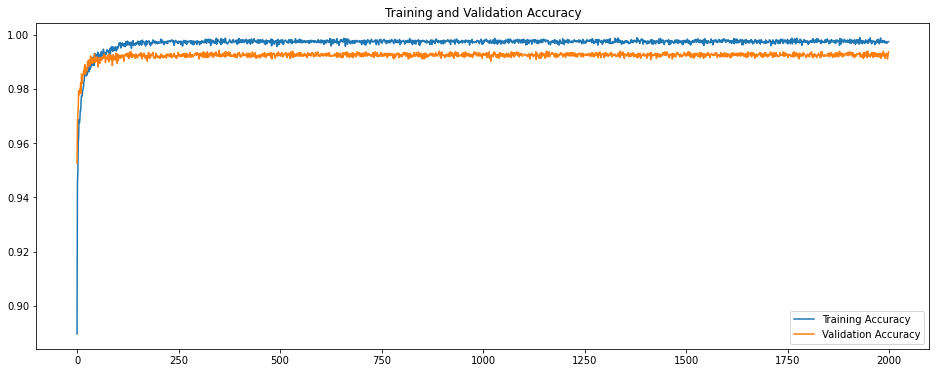

In [16]:
num_epochs=range(2000)
plt.figure(figsize=(16, 6))
plt.plot(num_epochs, train_acc, label='Training Accuracy')
plt.plot(num_epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.savefig('10.acc.jpg')
plt.show()

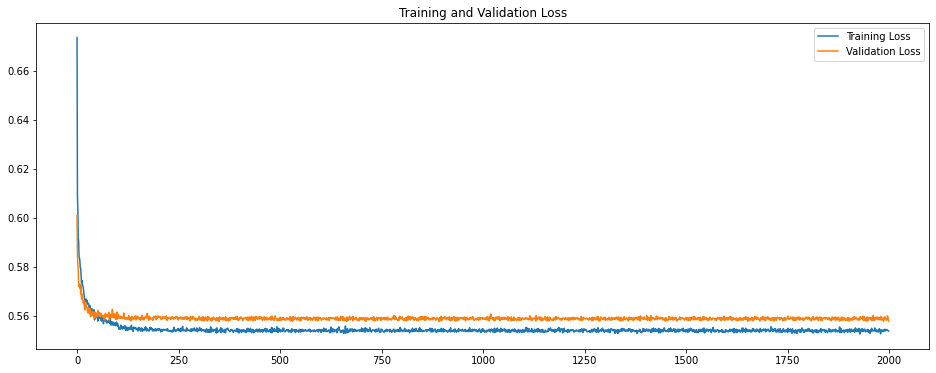

In [17]:
num_epochs=range(2000)
plt.figure(figsize=(16, 6))
plt.plot(num_epochs, train_loss, label='Training Loss')
plt.plot(num_epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('10_loss.jpg')
plt.show()

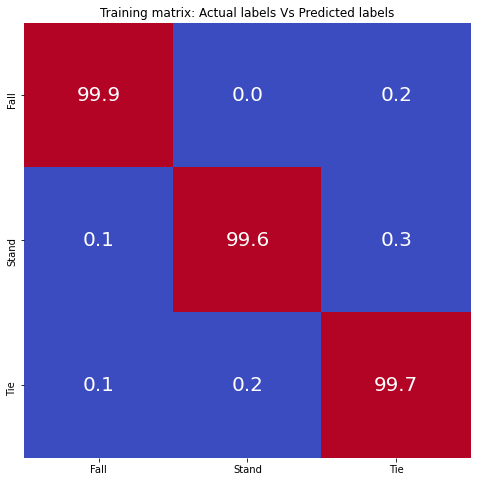

In [18]:
#set the size of figure 
plt.figure(figsize=(8,8))
#normalize each column (class) with total datapoints in that column  
conf_train = conf_train.astype('float')/conf_train.sum(axis=1)*100
#plot confusion matrix 
p=sns.heatmap(conf_train, xticklabels=['Fall','Stand','Tie'], yticklabels=['Fall','Stand','Tie'],
              cbar=False, annot=True, cmap='coolwarm',robust=True, fmt='.1f',annot_kws={'size':20})
plt.title('Training matrix: Actual labels Vs Predicted labels')
plt.savefig('conf_mat_10_train.png')

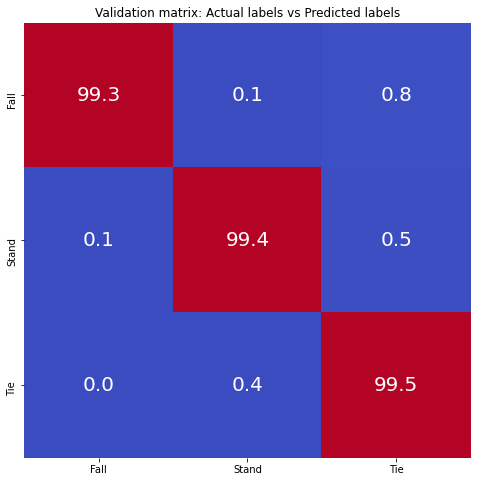

In [19]:
#set the size of figure 
plt.figure(figsize=(8,8))
#normalize each column (class) with total datapoints in that column  
conf_valid = conf_valid.astype('float')/conf_valid.sum(axis=1)*100
#plot confusion matrix 
p=sns.heatmap(conf_valid, xticklabels=['Fall','Stand','Tie'], yticklabels=['Fall','Stand','Tie'],
              cbar=False, annot=True, cmap='coolwarm',robust=True, fmt='.1f',annot_kws={'size':20})
plt.title('Validation matrix: Actual labels vs Predicted labels')
plt.savefig('conf_mat_10_valid.png')

In [20]:
def evaluate_model(model, dataloaders, dataset_sizes):
    #defaultdict to save list in dict
    history = defaultdict(list)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    model.eval() # Set model to evaluate mode
    phase = 'test'            
    running_loss = 0.0
    running_corrects = 0.0
    # Initialize the prediction and label lists(tensors)
    pred_tensor  = torch.zeros(0,dtype=torch.long, device='cpu')
    class_tensor = torch.zeros(0,dtype=torch.long, device='cpu')

    # enumerate over mini_batch
    for i, (inputs, targets)  in enumerate(dataloaders['test']):
        inputs  = inputs.to(device)
        targets = targets.to(device)

        # compute model outputs
        outputs = model(inputs)

        # calculate outputs
        _, preds = torch.max(outputs, dim=1)

        # calculate the loss
        loss = criterion(outputs, targets)

        #statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds==targets)

        # Append batch prediction results
        pred_tensor = torch.cat([pred_tensor,preds.view(-1).cpu()])
        class_tensor  = torch.cat([class_tensor,targets.view(-1).cpu()])
                
    #epoch loss and accuracy
    loss = running_loss / dataset_sizes['test'].__len__()
    acc  = running_corrects.double() / dataset_sizes['test'].__len__()
    history['test'].append((loss,acc))

    # Confusion matrix
    conf_mat = confusion_matrix(class_tensor.numpy(), pred_tensor.numpy())
    # Per-class accuracy
    per_class_accuracy = np.round(100*conf_mat.diagonal()/conf_mat.sum(1),4)
    #Precision, Recall, F1_Score
    precision = precision_score(class_tensor.numpy(), pred_tensor.numpy(), average='micro')
    recall = recall_score(class_tensor.numpy(), pred_tensor.numpy(), average='micro')
    f_score = f1_score(class_tensor.numpy(), pred_tensor.numpy(), average='micro')

    print('{} : Loss: {:.4f}, Acc: {:.4f}'.format(phase, loss, acc))
    print('{} : Confusion Matrix: {}, Per_class_accuracy: {}'.format(phase, conf_mat, per_class_accuracy))
    print('{} : Precision: {:.4f}, Recall: {:.4f}, F1_Score: {:.4f}'.format(phase, precision, recall, f_score))
    print()
            
    #set the size of figure 
    plt.figure(figsize=(8,8))
    #normalize each column (class) with total datapoints in that column  
    conf_mat = conf_mat.astype('float')/conf_mat.sum(axis=1)*100
    #plot confusion matrix 
    p=sns.heatmap(conf_mat, xticklabels=['Fall','Stand','Tie'], yticklabels=['Fall','Stand','Tie'],
              cbar=False, annot=True, cmap='coolwarm',robust=True, fmt='.1f',annot_kws={'size':20})
    plt.title('Test matrix: Actual labels Vs Predicted labels')
    plt.savefig('conf_mat_10_test.png')

test : Loss: 0.5595, Acc: 0.9918
test : Confusion Matrix: [[1420    3    5]
 [   7 1293    6]
 [   3    7 1029]], Per_class_accuracy: [99.4398 99.0046 99.0375]
test : Precision: 0.9918, Recall: 0.9918, F1_Score: 0.9918



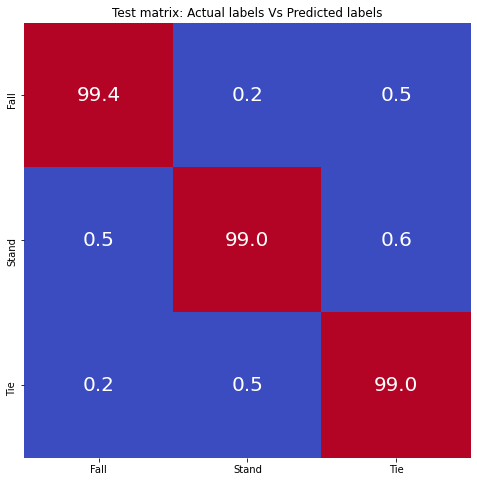

In [21]:
evaluate_model(model, dataloaders, dataset_sizes)